## 🧩 Cell 1 – Imports, device, seeds, multi-GPU config

In [1]:
# Cell 1: Imports, device selection, seeds, multi-GPU flags

import os
import random
from typing import Tuple, Optional, Dict

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import OneCycleLR
from torch.utils.data import DataLoader

import torchvision
from torchvision import transforms
from torchvision.transforms import v2
# from autonotebook import tqdm as notebook_tqdm
import matplotlib.pyplot as plt
import numpy as np
from torch.amp import autocast, GradScaler
from tqdm.auto import tqdm


def set_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = False  # allow autotune
    torch.backends.cudnn.benchmark = True       # optimize convs for fixed size


def get_device_and_parallel_flags():
    """
    Prefer CUDA; fall back to MPS; then CPU.
    If CUDA and multiple GPUs are available, enable DataParallel.
    """
    if torch.cuda.is_available():
        n_gpus = torch.cuda.device_count()
        device = torch.device("cuda")
        use_data_parallel = n_gpus > 1
        backend = "cuda"
    elif torch.backends.mps.is_available():
        device = torch.device("mps")
        use_data_parallel = False   # DP not supported on MPS
        backend = "mps"
    else:
        device = torch.device("cpu")
        use_data_parallel = False
        backend = "cpu"

    print(f"Backend: {backend}")
    print(f"Device: {device}")
    if backend == "cuda":
        print(f"Visible CUDA devices: {torch.cuda.device_count()}")
        if use_data_parallel:
            print("Using nn.DataParallel for multi-GPU.")
        else:
            print("Single GPU detected; running on cuda:0.")
    elif backend == "mps":
        print("Running on Apple Silicon (MPS).")
    else:
        print("Running on CPU (no GPU backend detected).")

    return device, use_data_parallel


set_seed(42)
device, USE_DATA_PARALLEL = get_device_and_parallel_flags()
USE_AMP = torch.cuda.is_available()
USE_CUTMIX = True      # you can flip this off later if you want
CUTMIX_ALPHA = 1.0
CUTMIX_PROB = 0.5
# Enable AMP on CUDA; disable on others for now
print("AMP (mixed precision) enabled:", USE_AMP)


/home/ec2-user/.local/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Backend: cuda
Device: cuda
Visible CUDA devices: 1
Single GPU detected; running on cuda:0.
AMP (mixed precision) enabled: True


## 🧩 Cell 2 – Transforms & Dataloaders (CUDA-optimized)

In [2]:
# Cell 2: Transforms & DataLoaders (optimized for NVIDIA GPUs / CUDA)

CIFAR100_MEAN = (0.5071, 0.4867, 0.4408)
CIFAR100_STD  = (0.2675, 0.2565, 0.2761)


def get_cifar100_transforms():
    """
    Uses torchvision v2 transforms (C++/vectorized) for speed.
    """
    train_transform = v2.Compose([
        v2.RandomCrop(32, padding=4),
        v2.RandomHorizontalFlip(),
        v2.RandomRotation(15),
        v2.ColorJitter(0.2, 0.2, 0.2, 0.02),
        v2.ToTensor(),
        v2.Normalize(CIFAR100_MEAN, CIFAR100_STD),
        v2.RandomErasing(p=0.5),
    ])

    test_transform = v2.Compose([
        v2.ToTensor(),
        v2.Normalize(CIFAR100_MEAN, CIFAR100_STD),
    ])

    return train_transform, test_transform


def get_cifar100_dataloaders(
    data_dir: str = "./data",
    batch_size: int = 512,           # slightly larger batch to exploit GPU
    num_workers: int = 8,            # tune based on vCPUs
) -> Tuple[DataLoader, DataLoader]:
    """
    DataLoader optimized for CUDA:
      - pin_memory=True
      - persistent_workers=True
      - prefetch_factor>1
    """
    train_transform, test_transform = get_cifar100_transforms()

    trainset = torchvision.datasets.CIFAR100(
        root=data_dir, train=True, download=True, transform=train_transform
    )
    testset = torchvision.datasets.CIFAR100(
        root=data_dir, train=False, download=True, transform=test_transform
    )

    cuda_like = torch.cuda.is_available()

    trainloader = DataLoader(
        trainset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=cuda_like,
        persistent_workers=num_workers > 0,
        prefetch_factor=4 if num_workers > 0 else 2,
    )

    testloader = DataLoader(
        testset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=cuda_like,
        persistent_workers=num_workers > 0,
        prefetch_factor=2 if num_workers > 0 else 2,
    )

    return trainloader, testloader


BATCH_SIZE = 512
NUM_WORKERS = 8  # adjust based on instance vCPUs
trainloader, testloader = get_cifar100_dataloaders(
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
)

len(trainloader), len(testloader)


/home/ec2-user/.local/lib/python3.9/site-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


(98, 20)

## 🧩 Cell 3 – ResNet (CIFAR-18) + param count + DataParallel

In [3]:
# Cell 3: ResNet for CIFAR-100 (ResNet-18 style) + param count + optional DataParallel

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes: int, planes: int, stride: int = 1):
        super().__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes,
            kernel_size=3, stride=stride,
            padding=1, bias=False
        )
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(
            planes, planes,
            kernel_size=3, stride=1,
            padding=1, bias=False
        )
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != planes * self.expansion:
            self.shortcut = nn.Sequential(
                nn.Conv2d(
                    in_planes, planes * self.expansion,
                    kernel_size=1, stride=stride, bias=False
                ),
                nn.BatchNorm2d(planes * self.expansion),
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out = out + self.shortcut(x)
        out = F.relu(out)
        return out


class ResNetCIFAR(nn.Module):
    def __init__(self, block, num_blocks, num_classes: int = 100):
        super().__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(
            3, 64,
            kernel_size=3, stride=1, padding=1, bias=False
        )
        self.bn1 = nn.BatchNorm2d(64)

        self.layer1 = self._make_layer(block, 64,  num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout(p=0.3)
        self.fc = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, planes: int, num_blocks: int, stride: int):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for s in strides:
            layers.append(block(self.in_planes, planes, s))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))  # 32x32
        out = self.layer1(out)                 # 32x32
        out = self.layer2(out)                 # 16x16
        out = self.layer3(out)                 # 8x8
        out = self.layer4(out)                 # 4x4
        out = self.avgpool(out)                # 1x1
        out = torch.flatten(out, 1)
        out = self.dropout(out)
        out = self.fc(out)
        return out


def resnet18_cifar(num_classes: int = 100) -> ResNetCIFAR:
    return ResNetCIFAR(BasicBlock, [2, 2, 2, 2], num_classes=num_classes)


def count_parameters(model: nn.Module):
    total = sum(p.numel() for p in model.parameters())
    trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return total, trainable, total - trainable


# Instantiate, move to device, optionally wrap in DataParallel
base_model = resnet18_cifar(num_classes=100).to(device)

if USE_DATA_PARALLEL:
    model = nn.DataParallel(base_model)
else:
    model = base_model

total, trainable, non_trainable = count_parameters(model)
print(model)
print(f"\nTotal parameters:     {total:,}")
print(f"Trainable parameters: {trainable:,}")
print(f"Frozen parameters:    {non_trainable:,}")


ResNetCIFAR(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, af

## 🧩 Cell 4 – Metrics, training & evaluation (with AMP + rich tqdm)

In [4]:
# Cell 4: Metrics, training & evaluation (AMP + rich tqdm)

def accuracy_top1(outputs: torch.Tensor, targets: torch.Tensor) -> float:
    _, preds = outputs.max(1)
    correct = preds.eq(targets).sum().item()
    return correct / targets.size(0)

def rand_bbox(size, lam):
    """Generate random bounding box for CutMix."""
    W = size[2]
    H = size[3]
    cut_rat = np.sqrt(1. - lam)
    cut_w = int(W * cut_rat)
    cut_h = int(H * cut_rat)

    cx = np.random.randint(W)
    cy = np.random.randint(H)

    x1 = np.clip(cx - cut_w // 2, 0, W)
    y1 = np.clip(cy - cut_h // 2, 0, H)
    x2 = np.clip(cx + cut_w // 2, 0, W)
    y2 = np.clip(cy + cut_h // 2, 0, H)

    return x1, y1, x2, y2


def apply_cutmix(inputs, targets, alpha=1.0, p=0.5, device="cuda"):
    """
    Apply CutMix with probability p and Beta(alpha, alpha) lam.
    Returns mixed inputs, target_a, target_b, lam.
    """
    if np.random.rand() > p or alpha <= 0.0:
        return inputs, targets, targets, 1.0

    lam = np.random.beta(alpha, alpha)
    batch_size = inputs.size(0)
    index = torch.randperm(batch_size).to(device)

    x1, y1, x2, y2 = rand_bbox(inputs.size(), lam)
    inputs[:, :, y1:y2, x1:x2] = inputs[index, :, y1:y2, x1:x2]
    y_a, y_b = targets, targets[index]

    # adjust lam to match the actual area
    lam = 1.0 - ((x2 - x1) * (y2 - y1) / (inputs.size(-1) * inputs.size(-2)))
    return inputs, y_a, y_b, lam


def cutmix_criterion(criterion, preds, y_a, y_b, lam):
    return lam * criterion(preds, y_a) + (1.0 - lam) * criterion(preds, y_b)

def train_one_epoch(
    model: nn.Module,
    device: torch.device,
    loader: DataLoader,
    optimizer: optim.Optimizer,
    criterion: nn.Module,
    scheduler: Optional[OneCycleLR],
    epoch: int,
    total_epochs: int,
    use_amp: bool = True,
    use_cutmix: bool = False,
    cutmix_alpha: float = 1.0,
    cutmix_prob: float = 0.5,
) -> Tuple[float, float]:
    model.train()
    running_loss = 0.0
    running_correct = 0
    running_total = 0

    scaler = GradScaler("cuda", enabled=use_amp and (device.type == "cuda"))

    pbar = tqdm(loader, total=len(loader))
    pbar.set_description(f"Epoch [{epoch}/{total_epochs}] (Train)")

    for batch_idx, (inputs, targets) in enumerate(pbar):
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad(set_to_none=True)

        # ----- CutMix step -----
        if use_cutmix:
            inputs, targets_a, targets_b, lam = apply_cutmix(
                inputs,
                targets,
                alpha=cutmix_alpha,
                p=cutmix_prob,
                device=device,
            )
        else:
            targets_a, targets_b, lam = targets, targets, 1.0

        # ----- Forward + loss (with AMP) -----
        if use_amp and device.type == "cuda":
            with autocast("cuda"):
                outputs = model(inputs)
                if use_cutmix:
                    loss = cutmix_criterion(criterion, outputs, targets_a, targets_b, lam)
                else:
                    loss = criterion(outputs, targets)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            outputs = model(inputs)
            if use_cutmix:
                loss = cutmix_criterion(criterion, outputs, targets_a, targets_b, lam)
            else:
                loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

        if scheduler is not None:
            scheduler.step()

        batch_size = targets.size(0)
        running_loss += loss.item() * batch_size
        running_total += batch_size

        # For accuracy, we still compare against the original targets (not mixed)
        _, preds = outputs.max(1)
        running_correct += preds.eq(targets).sum().item()

        avg_loss = running_loss / running_total
        avg_acc = running_correct / running_total
        current_lr = optimizer.param_groups[0]["lr"]

        pbar.set_postfix({
            "batch_loss": f"{loss.item():.4f}",
            "avg_loss": f"{avg_loss:.4f}",
            "avg_acc": f"{avg_acc*100:.2f}%",
            "lr": f"{current_lr:.5f}",
            "seen": running_total,
        })

    epoch_loss = running_loss / running_total
    epoch_acc = running_correct / running_total
    return epoch_loss, epoch_acc


def evaluate(
    model: nn.Module,
    device: torch.device,
    loader: DataLoader,
    criterion: nn.Module,
    epoch: int,
    total_epochs: int,
) -> Tuple[float, float]:
    model.eval()
    running_loss = 0.0
    running_correct = 0
    running_total = 0

    pbar = tqdm(loader, total=len(loader))
    pbar.set_description(f"Epoch [{epoch}/{total_epochs}] (Eval)")

    with torch.no_grad():
        for inputs, targets in pbar:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            batch_size = targets.size(0)
            running_loss += loss.item() * batch_size
            running_total += batch_size

            _, preds = outputs.max(1)
            running_correct += preds.eq(targets).sum().item()

            avg_loss = running_loss / running_total
            avg_acc = running_correct / running_total

            pbar.set_postfix({
                "avg_loss": f"{avg_loss:.4f}",
                "avg_acc": f"{avg_acc*100:.2f}%",
                "seen": running_total,
            })

    epoch_loss = running_loss / running_total
    epoch_acc = running_correct / running_total
    return epoch_loss, epoch_acc


def plot_training_curves(
    history: Dict[str, list],
    out_dir: str = "./plots",
):
    os.makedirs(out_dir, exist_ok=True)
    epochs = len(history["train_loss"])
    xs = range(1, epochs + 1)

    # Loss curve
    plt.figure()
    plt.plot(xs, history["train_loss"], label="Train Loss")
    plt.plot(xs, history["test_loss"], label="Test Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Loss vs Epoch")
    plt.legend()
    plt.grid(True)
    plt.savefig(os.path.join(out_dir, "loss_curve.png"))
    plt.show()

    # Accuracy curve
    plt.figure()
    plt.plot(xs, np.array(history["train_acc"]) * 100, label="Train Acc")
    plt.plot(xs, np.array(history["test_acc"]) * 100, label="Test Acc")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy (%)")
    plt.title("Accuracy vs Epoch")
    plt.legend()
    plt.grid(True)
    plt.savefig(os.path.join(out_dir, "accuracy_curve.png"))
    plt.show()


## 🧩 Cell 5 – Training orchestrator (Markdown logs + save best model, DP-safe)

In [5]:
# Cell 5: Full training loop (Markdown logs + DP-safe checkpointing)

def get_state_dict_for_saving(model: nn.Module) -> Dict[str, torch.Tensor]:
    """
    Handles both plain model and DataParallel-wrapped model.
    """
    if isinstance(model, nn.DataParallel):
        return model.module.state_dict()
    return model.state_dict()


def train_resnet_cifar100(
    device: torch.device,
    use_data_parallel: bool,
    use_amp: bool,
    epochs: int = 100,
    batch_size: int = 256,
    max_lr: float = 0.1,
    data_dir: str = "./data",
    log_markdown_path: str = "./training_logs.md",
    model_ckpt_path: str = "./best_resnet_cifar100.pth",
):
    # Data
    trainloader, testloader = get_cifar100_dataloaders(
        data_dir=data_dir,
        batch_size=batch_size,
        num_workers=NUM_WORKERS,
    )

    # Model
    base_model = resnet18_cifar(num_classes=100).to(device)
    if use_data_parallel:
        model = nn.DataParallel(base_model)
    else:
        model = base_model

    # criterion = nn.CrossEntropyLoss().to(device)
    criterion = nn.CrossEntropyLoss(label_smoothing=0.1).to(device)

    optimizer = optim.SGD(
        model.parameters(),
        lr=max_lr,
        momentum=0.9,
        weight_decay=5e-4,
    )

    steps_per_epoch = len(trainloader)
    scheduler = OneCycleLR(
        optimizer,
        max_lr=max_lr,
        steps_per_epoch=steps_per_epoch,
        epochs=epochs,
        pct_start=0.3,
        div_factor=10,
        final_div_factor=1e4,
    )

    history = {
        "train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": [],
    }

    # Markdown log file (assignment requirement)
    f = open(log_markdown_path, "w", encoding="utf-8")
    f.write("# Training Logs: ResNet-18 on CIFAR-100\n\n")
    f.write("| Epoch | Train Loss | Train Acc (%) | Test Loss | Test Acc (%) |\n")
    f.write("|-------|------------|---------------|-----------|--------------|\n")

    best_test_acc = 0.0

    # Warm-up pass (helps cuDNN autotune)
    with torch.no_grad():
        dummy = torch.randn(1, 3, 32, 32).to(device)
        _ = model(dummy)

    for epoch in range(1, epochs + 1):
        train_loss, train_acc = train_one_epoch(
            model=model,
            device=device,
            loader=trainloader,
            optimizer=optimizer,
            criterion=criterion,
            scheduler=scheduler,
            epoch=epoch,
            total_epochs=epochs,
            use_amp=use_amp and torch.cuda.is_available(),
            use_cutmix=USE_CUTMIX,
            cutmix_alpha=CUTMIX_ALPHA,
            cutmix_prob=CUTMIX_PROB,
        )

        test_loss, test_acc = evaluate(
            model=model,
            device=device,
            loader=testloader,
            criterion=criterion,
            epoch=epoch,
            total_epochs=epochs,
        )

        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)
        history["test_loss"].append(test_loss)
        history["test_acc"].append(test_acc)

        # Write Markdown row
        f.write(
            f"| {epoch} | {train_loss:.4f} | {train_acc*100:.2f} | "
            f"{test_loss:.4f} | {test_acc*100:.2f} |\n"
        )
        f.flush()

        print(
            f"[Epoch {epoch}/{epochs}] "
            f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc*100:.2f}% | "
            f"Test Loss: {test_loss:.4f} | Test Acc: {test_acc*100:.2f}%"
        )

        # Save best model (DP-safe)
        if test_acc > best_test_acc:
            best_test_acc = test_acc
            torch.save(
                {"model_state_dict": get_state_dict_for_saving(model)},
                model_ckpt_path,
            )

    f.close()

    return model, history


## 🧩 Cell 6 – Run training & plot curves

Epoch [1/150] (Train): 100%|█| 98/98 [00:34<00:00,  2.88it/s, batch_loss=3.9994, avg_loss=4.3685, avg_acc=5.18%, l
Epoch [1/150] (Eval): 100%|███████████| 20/20 [00:02<00:00,  9.90it/s, avg_loss=3.9975, avg_acc=10.94%, seen=1e+4]


[Epoch 1/150] Train Loss: 4.3685 | Train Acc: 5.18% | Test Loss: 3.9975 | Test Acc: 10.94%


Epoch [2/150] (Train): 100%|█| 98/98 [00:12<00:00,  7.98it/s, batch_loss=3.7936, avg_loss=4.0455, avg_acc=10.49%, 
Epoch [2/150] (Eval): 100%|███████████| 20/20 [00:01<00:00, 15.10it/s, avg_loss=3.7528, avg_acc=14.91%, seen=1e+4]


[Epoch 2/150] Train Loss: 4.0455 | Train Acc: 10.49% | Test Loss: 3.7528 | Test Acc: 14.91%


Epoch [3/150] (Train): 100%|█| 98/98 [00:12<00:00,  7.97it/s, batch_loss=4.1533, avg_loss=3.8812, avg_acc=14.52%, 
Epoch [3/150] (Eval): 100%|███████████| 20/20 [00:01<00:00, 15.14it/s, avg_loss=3.4296, avg_acc=22.32%, seen=1e+4]


[Epoch 3/150] Train Loss: 3.8812 | Train Acc: 14.52% | Test Loss: 3.4296 | Test Acc: 22.32%


Epoch [4/150] (Train): 100%|█| 98/98 [00:12<00:00,  7.95it/s, batch_loss=3.6739, avg_loss=3.7444, avg_acc=17.56%, 
Epoch [4/150] (Eval): 100%|███████████| 20/20 [00:01<00:00, 15.03it/s, avg_loss=3.3004, avg_acc=25.05%, seen=1e+4]


[Epoch 4/150] Train Loss: 3.7444 | Train Acc: 17.56% | Test Loss: 3.3004 | Test Acc: 25.05%


Epoch [5/150] (Train): 100%|█| 98/98 [00:12<00:00,  7.76it/s, batch_loss=4.1272, avg_loss=3.6158, avg_acc=20.62%, 
Epoch [5/150] (Eval): 100%|███████████| 20/20 [00:01<00:00, 15.24it/s, avg_loss=3.1712, avg_acc=28.85%, seen=1e+4]


[Epoch 5/150] Train Loss: 3.6158 | Train Acc: 20.62% | Test Loss: 3.1712 | Test Acc: 28.85%


Epoch [6/150] (Train): 100%|█| 98/98 [00:12<00:00,  7.98it/s, batch_loss=3.0716, avg_loss=3.4578, avg_acc=24.05%, 
Epoch [6/150] (Eval): 100%|███████████| 20/20 [00:01<00:00, 15.96it/s, avg_loss=3.1086, avg_acc=31.58%, seen=1e+4]


[Epoch 6/150] Train Loss: 3.4578 | Train Acc: 24.05% | Test Loss: 3.1086 | Test Acc: 31.58%


Epoch [7/150] (Train): 100%|█| 98/98 [00:12<00:00,  7.98it/s, batch_loss=3.0328, avg_loss=3.4713, avg_acc=24.56%, 
Epoch [7/150] (Eval): 100%|███████████| 20/20 [00:01<00:00, 15.55it/s, avg_loss=3.0380, avg_acc=31.61%, seen=1e+4]


[Epoch 7/150] Train Loss: 3.4713 | Train Acc: 24.56% | Test Loss: 3.0380 | Test Acc: 31.61%


Epoch [8/150] (Train): 100%|█| 98/98 [00:12<00:00,  7.96it/s, batch_loss=3.3565, avg_loss=3.3371, avg_acc=26.64%, 
Epoch [8/150] (Eval): 100%|███████████| 20/20 [00:01<00:00, 15.01it/s, avg_loss=2.8528, avg_acc=37.17%, seen=1e+4]


[Epoch 8/150] Train Loss: 3.3371 | Train Acc: 26.64% | Test Loss: 2.8528 | Test Acc: 37.17%


Epoch [9/150] (Train): 100%|█| 98/98 [00:12<00:00,  7.93it/s, batch_loss=3.6568, avg_loss=3.2906, avg_acc=29.50%, 
Epoch [9/150] (Eval): 100%|███████████| 20/20 [00:01<00:00, 15.76it/s, avg_loss=2.8658, avg_acc=36.33%, seen=1e+4]


[Epoch 9/150] Train Loss: 3.2906 | Train Acc: 29.50% | Test Loss: 2.8658 | Test Acc: 36.33%


Epoch [10/150] (Train): 100%|█| 98/98 [00:12<00:00,  7.92it/s, batch_loss=2.6360, avg_loss=3.1102, avg_acc=33.41%,
Epoch [10/150] (Eval): 100%|██████████| 20/20 [00:01<00:00, 15.29it/s, avg_loss=2.7916, avg_acc=38.31%, seen=1e+4]


[Epoch 10/150] Train Loss: 3.1102 | Train Acc: 33.41% | Test Loss: 2.7916 | Test Acc: 38.31%


Epoch [11/150] (Train): 100%|█| 98/98 [00:12<00:00,  7.85it/s, batch_loss=3.7212, avg_loss=3.0903, avg_acc=34.74%,
Epoch [11/150] (Eval): 100%|██████████| 20/20 [00:01<00:00, 15.30it/s, avg_loss=2.5979, avg_acc=43.88%, seen=1e+4]


[Epoch 11/150] Train Loss: 3.0903 | Train Acc: 34.74% | Test Loss: 2.5979 | Test Acc: 43.88%


Epoch [12/150] (Train): 100%|█| 98/98 [00:12<00:00,  7.88it/s, batch_loss=3.7271, avg_loss=3.0550, avg_acc=35.96%,
Epoch [12/150] (Eval): 100%|██████████| 20/20 [00:01<00:00, 15.01it/s, avg_loss=2.5865, avg_acc=44.11%, seen=1e+4]


[Epoch 12/150] Train Loss: 3.0550 | Train Acc: 35.96% | Test Loss: 2.5865 | Test Acc: 44.11%


Epoch [13/150] (Train): 100%|█| 98/98 [00:12<00:00,  7.97it/s, batch_loss=3.2205, avg_loss=3.0210, avg_acc=36.29%,
Epoch [13/150] (Eval): 100%|██████████| 20/20 [00:01<00:00, 15.27it/s, avg_loss=2.8118, avg_acc=39.33%, seen=1e+4]


[Epoch 13/150] Train Loss: 3.0210 | Train Acc: 36.29% | Test Loss: 2.8118 | Test Acc: 39.33%


Epoch [14/150] (Train): 100%|█| 98/98 [00:12<00:00,  7.92it/s, batch_loss=3.2701, avg_loss=2.9081, avg_acc=39.82%,
Epoch [14/150] (Eval): 100%|██████████| 20/20 [00:01<00:00, 15.46it/s, avg_loss=2.4133, avg_acc=48.48%, seen=1e+4]


[Epoch 14/150] Train Loss: 2.9081 | Train Acc: 39.82% | Test Loss: 2.4133 | Test Acc: 48.48%


Epoch [15/150] (Train): 100%|█| 98/98 [00:12<00:00,  7.84it/s, batch_loss=2.4506, avg_loss=2.9105, avg_acc=38.36%,
Epoch [15/150] (Eval): 100%|██████████| 20/20 [00:01<00:00, 15.09it/s, avg_loss=2.3353, avg_acc=51.52%, seen=1e+4]


[Epoch 15/150] Train Loss: 2.9105 | Train Acc: 38.36% | Test Loss: 2.3353 | Test Acc: 51.52%


Epoch [16/150] (Train): 100%|█| 98/98 [00:12<00:00,  7.88it/s, batch_loss=3.6910, avg_loss=2.8614, avg_acc=41.22%,
Epoch [16/150] (Eval): 100%|██████████| 20/20 [00:01<00:00, 14.91it/s, avg_loss=2.3683, avg_acc=50.12%, seen=1e+4]


[Epoch 16/150] Train Loss: 2.8614 | Train Acc: 41.22% | Test Loss: 2.3683 | Test Acc: 50.12%


Epoch [17/150] (Train): 100%|█| 98/98 [00:12<00:00,  8.02it/s, batch_loss=3.7796, avg_loss=2.9017, avg_acc=40.20%,
Epoch [17/150] (Eval): 100%|██████████| 20/20 [00:01<00:00, 15.62it/s, avg_loss=2.3047, avg_acc=52.94%, seen=1e+4]


[Epoch 17/150] Train Loss: 2.9017 | Train Acc: 40.20% | Test Loss: 2.3047 | Test Acc: 52.94%


Epoch [18/150] (Train): 100%|█| 98/98 [00:12<00:00,  7.96it/s, batch_loss=2.2554, avg_loss=2.8303, avg_acc=42.33%,
Epoch [18/150] (Eval): 100%|██████████| 20/20 [00:01<00:00, 16.00it/s, avg_loss=2.2726, avg_acc=53.30%, seen=1e+4]


[Epoch 18/150] Train Loss: 2.8303 | Train Acc: 42.33% | Test Loss: 2.2726 | Test Acc: 53.30%


Epoch [19/150] (Train): 100%|█| 98/98 [00:12<00:00,  7.95it/s, batch_loss=2.2655, avg_loss=2.8057, avg_acc=44.07%,
Epoch [19/150] (Eval): 100%|██████████| 20/20 [00:01<00:00, 15.31it/s, avg_loss=2.2177, avg_acc=54.33%, seen=1e+4]


[Epoch 19/150] Train Loss: 2.8057 | Train Acc: 44.07% | Test Loss: 2.2177 | Test Acc: 54.33%


Epoch [20/150] (Train): 100%|█| 98/98 [00:12<00:00,  7.82it/s, batch_loss=2.8860, avg_loss=2.6871, avg_acc=45.71%,
Epoch [20/150] (Eval): 100%|██████████| 20/20 [00:01<00:00, 15.69it/s, avg_loss=2.2385, avg_acc=54.61%, seen=1e+4]


[Epoch 20/150] Train Loss: 2.6871 | Train Acc: 45.71% | Test Loss: 2.2385 | Test Acc: 54.61%


Epoch [21/150] (Train): 100%|█| 98/98 [00:12<00:00,  7.81it/s, batch_loss=2.1887, avg_loss=2.8582, avg_acc=42.41%,
Epoch [21/150] (Eval): 100%|██████████| 20/20 [00:01<00:00, 15.41it/s, avg_loss=2.1918, avg_acc=55.21%, seen=1e+4]


[Epoch 21/150] Train Loss: 2.8582 | Train Acc: 42.41% | Test Loss: 2.1918 | Test Acc: 55.21%


Epoch [22/150] (Train): 100%|█| 98/98 [00:12<00:00,  7.92it/s, batch_loss=3.0000, avg_loss=2.7113, avg_acc=46.51%,
Epoch [22/150] (Eval): 100%|██████████| 20/20 [00:01<00:00, 15.23it/s, avg_loss=2.2373, avg_acc=54.87%, seen=1e+4]


[Epoch 22/150] Train Loss: 2.7113 | Train Acc: 46.51% | Test Loss: 2.2373 | Test Acc: 54.87%


Epoch [23/150] (Train): 100%|█| 98/98 [00:12<00:00,  7.96it/s, batch_loss=2.3164, avg_loss=2.7350, avg_acc=43.94%,
Epoch [23/150] (Eval): 100%|██████████| 20/20 [00:01<00:00, 15.16it/s, avg_loss=2.2157, avg_acc=55.19%, seen=1e+4]


[Epoch 23/150] Train Loss: 2.7350 | Train Acc: 43.94% | Test Loss: 2.2157 | Test Acc: 55.19%


Epoch [24/150] (Train): 100%|█| 98/98 [00:12<00:00,  7.90it/s, batch_loss=2.1123, avg_loss=2.7212, avg_acc=45.54%,
Epoch [24/150] (Eval): 100%|██████████| 20/20 [00:01<00:00, 15.62it/s, avg_loss=2.1850, avg_acc=56.35%, seen=1e+4]


[Epoch 24/150] Train Loss: 2.7212 | Train Acc: 45.54% | Test Loss: 2.1850 | Test Acc: 56.35%


Epoch [25/150] (Train): 100%|█| 98/98 [00:12<00:00,  7.90it/s, batch_loss=2.1987, avg_loss=2.6839, avg_acc=46.40%,
Epoch [25/150] (Eval): 100%|██████████| 20/20 [00:01<00:00, 14.10it/s, avg_loss=2.2202, avg_acc=54.12%, seen=1e+4]


[Epoch 25/150] Train Loss: 2.6839 | Train Acc: 46.40% | Test Loss: 2.2202 | Test Acc: 54.12%


Epoch [26/150] (Train): 100%|█| 98/98 [00:12<00:00,  7.88it/s, batch_loss=3.2903, avg_loss=2.8059, avg_acc=41.72%,
Epoch [26/150] (Eval): 100%|██████████| 20/20 [00:01<00:00, 15.34it/s, avg_loss=2.1814, avg_acc=57.59%, seen=1e+4]


[Epoch 26/150] Train Loss: 2.8059 | Train Acc: 41.72% | Test Loss: 2.1814 | Test Acc: 57.59%


Epoch [27/150] (Train): 100%|█| 98/98 [00:12<00:00,  7.85it/s, batch_loss=2.1037, avg_loss=2.5342, avg_acc=49.91%,
Epoch [27/150] (Eval): 100%|██████████| 20/20 [00:01<00:00, 15.19it/s, avg_loss=2.0797, avg_acc=58.68%, seen=1e+4]


[Epoch 27/150] Train Loss: 2.5342 | Train Acc: 49.91% | Test Loss: 2.0797 | Test Acc: 58.68%


Epoch [28/150] (Train): 100%|█| 98/98 [00:12<00:00,  7.93it/s, batch_loss=3.3557, avg_loss=2.5817, avg_acc=50.08%,
Epoch [28/150] (Eval): 100%|██████████| 20/20 [00:01<00:00, 15.78it/s, avg_loss=2.0962, avg_acc=58.80%, seen=1e+4]


[Epoch 28/150] Train Loss: 2.5817 | Train Acc: 50.08% | Test Loss: 2.0962 | Test Acc: 58.80%


Epoch [29/150] (Train): 100%|█| 98/98 [00:12<00:00,  7.90it/s, batch_loss=2.0606, avg_loss=2.6209, avg_acc=47.69%,
Epoch [29/150] (Eval): 100%|██████████| 20/20 [00:01<00:00, 14.44it/s, avg_loss=2.1183, avg_acc=58.01%, seen=1e+4]


[Epoch 29/150] Train Loss: 2.6209 | Train Acc: 47.69% | Test Loss: 2.1183 | Test Acc: 58.01%


Epoch [30/150] (Train): 100%|█| 98/98 [00:12<00:00,  7.76it/s, batch_loss=2.1367, avg_loss=2.5531, avg_acc=49.74%,
Epoch [30/150] (Eval): 100%|██████████| 20/20 [00:01<00:00, 15.23it/s, avg_loss=2.1344, avg_acc=58.69%, seen=1e+4]


[Epoch 30/150] Train Loss: 2.5531 | Train Acc: 49.74% | Test Loss: 2.1344 | Test Acc: 58.69%


Epoch [31/150] (Train): 100%|█| 98/98 [00:12<00:00,  7.97it/s, batch_loss=2.9505, avg_loss=2.5564, avg_acc=50.76%,
Epoch [31/150] (Eval): 100%|██████████| 20/20 [00:01<00:00, 15.58it/s, avg_loss=2.1951, avg_acc=55.75%, seen=1e+4]


[Epoch 31/150] Train Loss: 2.5564 | Train Acc: 50.76% | Test Loss: 2.1951 | Test Acc: 55.75%


Epoch [32/150] (Train): 100%|█| 98/98 [00:12<00:00,  7.87it/s, batch_loss=2.1443, avg_loss=2.4880, avg_acc=51.91%,
Epoch [32/150] (Eval): 100%|██████████| 20/20 [00:01<00:00, 15.63it/s, avg_loss=2.1631, avg_acc=56.90%, seen=1e+4]


[Epoch 32/150] Train Loss: 2.4880 | Train Acc: 51.91% | Test Loss: 2.1631 | Test Acc: 56.90%


Epoch [33/150] (Train): 100%|█| 98/98 [00:12<00:00,  7.82it/s, batch_loss=1.9581, avg_loss=2.4186, avg_acc=53.89%,
Epoch [33/150] (Eval): 100%|██████████| 20/20 [00:01<00:00, 15.62it/s, avg_loss=2.1851, avg_acc=56.67%, seen=1e+4]


[Epoch 33/150] Train Loss: 2.4186 | Train Acc: 53.89% | Test Loss: 2.1851 | Test Acc: 56.67%


Epoch [34/150] (Train): 100%|█| 98/98 [00:12<00:00,  7.98it/s, batch_loss=3.2544, avg_loss=2.5982, avg_acc=49.34%,
Epoch [34/150] (Eval): 100%|██████████| 20/20 [00:01<00:00, 15.09it/s, avg_loss=2.0706, avg_acc=59.93%, seen=1e+4]


[Epoch 34/150] Train Loss: 2.5982 | Train Acc: 49.34% | Test Loss: 2.0706 | Test Acc: 59.93%


Epoch [35/150] (Train): 100%|█| 98/98 [00:12<00:00,  7.79it/s, batch_loss=3.5878, avg_loss=2.4521, avg_acc=53.15%,
Epoch [35/150] (Eval): 100%|██████████| 20/20 [00:01<00:00, 15.15it/s, avg_loss=2.0919, avg_acc=58.38%, seen=1e+4]


[Epoch 35/150] Train Loss: 2.4521 | Train Acc: 53.15% | Test Loss: 2.0919 | Test Acc: 58.38%


Epoch [36/150] (Train): 100%|█| 98/98 [00:12<00:00,  7.95it/s, batch_loss=1.9914, avg_loss=2.3313, avg_acc=56.40%,
Epoch [36/150] (Eval): 100%|██████████| 20/20 [00:01<00:00, 15.68it/s, avg_loss=2.0392, avg_acc=60.03%, seen=1e+4]


[Epoch 36/150] Train Loss: 2.3313 | Train Acc: 56.40% | Test Loss: 2.0392 | Test Acc: 60.03%


Epoch [37/150] (Train): 100%|█| 98/98 [00:12<00:00,  7.92it/s, batch_loss=1.9421, avg_loss=2.5071, avg_acc=53.56%,
Epoch [37/150] (Eval): 100%|██████████| 20/20 [00:01<00:00, 15.32it/s, avg_loss=2.1302, avg_acc=57.33%, seen=1e+4]


[Epoch 37/150] Train Loss: 2.5071 | Train Acc: 53.56% | Test Loss: 2.1302 | Test Acc: 57.33%


Epoch [38/150] (Train): 100%|█| 98/98 [00:12<00:00,  7.93it/s, batch_loss=1.9110, avg_loss=2.3535, avg_acc=56.48%,
Epoch [38/150] (Eval): 100%|██████████| 20/20 [00:01<00:00, 15.58it/s, avg_loss=2.0317, avg_acc=60.42%, seen=1e+4]


[Epoch 38/150] Train Loss: 2.3535 | Train Acc: 56.48% | Test Loss: 2.0317 | Test Acc: 60.42%


Epoch [39/150] (Train): 100%|█| 98/98 [00:12<00:00,  7.96it/s, batch_loss=2.2922, avg_loss=2.4301, avg_acc=51.82%,
Epoch [39/150] (Eval): 100%|██████████| 20/20 [00:01<00:00, 14.75it/s, avg_loss=1.9584, avg_acc=63.09%, seen=1e+4]


[Epoch 39/150] Train Loss: 2.4301 | Train Acc: 51.82% | Test Loss: 1.9584 | Test Acc: 63.09%


Epoch [40/150] (Train): 100%|█| 98/98 [00:12<00:00,  7.99it/s, batch_loss=3.4924, avg_loss=2.3658, avg_acc=55.70%,
Epoch [40/150] (Eval): 100%|██████████| 20/20 [00:01<00:00, 15.57it/s, avg_loss=1.9355, avg_acc=63.62%, seen=1e+4]


[Epoch 40/150] Train Loss: 2.3658 | Train Acc: 55.70% | Test Loss: 1.9355 | Test Acc: 63.62%


Epoch [41/150] (Train): 100%|█| 98/98 [00:12<00:00,  7.96it/s, batch_loss=3.5763, avg_loss=2.4561, avg_acc=52.97%,
Epoch [41/150] (Eval): 100%|██████████| 20/20 [00:01<00:00, 14.87it/s, avg_loss=2.1129, avg_acc=58.88%, seen=1e+4]


[Epoch 41/150] Train Loss: 2.4561 | Train Acc: 52.97% | Test Loss: 2.1129 | Test Acc: 58.88%


Epoch [42/150] (Train): 100%|█| 98/98 [00:12<00:00,  7.90it/s, batch_loss=3.1579, avg_loss=2.4213, avg_acc=54.78%,
Epoch [42/150] (Eval): 100%|██████████| 20/20 [00:01<00:00, 15.21it/s, avg_loss=2.0351, avg_acc=61.06%, seen=1e+4]


[Epoch 42/150] Train Loss: 2.4213 | Train Acc: 54.78% | Test Loss: 2.0351 | Test Acc: 61.06%


Epoch [43/150] (Train): 100%|█| 98/98 [00:12<00:00,  7.79it/s, batch_loss=1.7682, avg_loss=2.2954, avg_acc=58.46%,
Epoch [43/150] (Eval): 100%|██████████| 20/20 [00:01<00:00, 15.05it/s, avg_loss=1.9403, avg_acc=63.69%, seen=1e+4]


[Epoch 43/150] Train Loss: 2.2954 | Train Acc: 58.46% | Test Loss: 1.9403 | Test Acc: 63.69%


Epoch [44/150] (Train): 100%|█| 98/98 [00:12<00:00,  7.85it/s, batch_loss=1.8683, avg_loss=2.3996, avg_acc=56.35%,
Epoch [44/150] (Eval): 100%|██████████| 20/20 [00:01<00:00, 15.33it/s, avg_loss=1.9605, avg_acc=63.44%, seen=1e+4]


[Epoch 44/150] Train Loss: 2.3996 | Train Acc: 56.35% | Test Loss: 1.9605 | Test Acc: 63.44%


Epoch [45/150] (Train): 100%|█| 98/98 [00:12<00:00,  7.95it/s, batch_loss=1.7013, avg_loss=2.3480, avg_acc=56.92%,
Epoch [45/150] (Eval): 100%|██████████| 20/20 [00:01<00:00, 15.77it/s, avg_loss=1.9633, avg_acc=62.41%, seen=1e+4]


[Epoch 45/150] Train Loss: 2.3480 | Train Acc: 56.92% | Test Loss: 1.9633 | Test Acc: 62.41%


Epoch [46/150] (Train): 100%|█| 98/98 [00:12<00:00,  7.78it/s, batch_loss=2.0386, avg_loss=2.3902, avg_acc=53.97%,
Epoch [46/150] (Eval): 100%|██████████| 20/20 [00:01<00:00, 15.57it/s, avg_loss=2.0453, avg_acc=60.01%, seen=1e+4]


[Epoch 46/150] Train Loss: 2.3902 | Train Acc: 53.97% | Test Loss: 2.0453 | Test Acc: 60.01%


Epoch [47/150] (Train): 100%|█| 98/98 [00:12<00:00,  7.94it/s, batch_loss=1.7997, avg_loss=2.3010, avg_acc=56.46%,
Epoch [47/150] (Eval): 100%|██████████| 20/20 [00:01<00:00, 15.45it/s, avg_loss=1.9265, avg_acc=63.13%, seen=1e+4]


[Epoch 47/150] Train Loss: 2.3010 | Train Acc: 56.46% | Test Loss: 1.9265 | Test Acc: 63.13%


Epoch [48/150] (Train): 100%|█| 98/98 [00:12<00:00,  7.96it/s, batch_loss=3.4665, avg_loss=2.2269, avg_acc=59.50%,
Epoch [48/150] (Eval): 100%|██████████| 20/20 [00:01<00:00, 15.43it/s, avg_loss=1.8730, avg_acc=65.15%, seen=1e+4]


[Epoch 48/150] Train Loss: 2.2269 | Train Acc: 59.50% | Test Loss: 1.8730 | Test Acc: 65.15%


Epoch [49/150] (Train): 100%|█| 98/98 [00:12<00:00,  7.98it/s, batch_loss=1.8027, avg_loss=2.2979, avg_acc=58.02%,
Epoch [49/150] (Eval): 100%|██████████| 20/20 [00:01<00:00, 15.44it/s, avg_loss=1.8867, avg_acc=64.72%, seen=1e+4]


[Epoch 49/150] Train Loss: 2.2979 | Train Acc: 58.02% | Test Loss: 1.8867 | Test Acc: 64.72%


Epoch [50/150] (Train): 100%|█| 98/98 [00:12<00:00,  7.89it/s, batch_loss=1.7091, avg_loss=2.2324, avg_acc=59.39%,
Epoch [50/150] (Eval): 100%|██████████| 20/20 [00:01<00:00, 15.40it/s, avg_loss=1.8846, avg_acc=65.02%, seen=1e+4]


[Epoch 50/150] Train Loss: 2.2324 | Train Acc: 59.39% | Test Loss: 1.8846 | Test Acc: 65.02%


Epoch [51/150] (Train): 100%|█| 98/98 [00:12<00:00,  7.95it/s, batch_loss=2.7363, avg_loss=2.2224, avg_acc=60.04%,
Epoch [51/150] (Eval): 100%|██████████| 20/20 [00:01<00:00, 15.19it/s, avg_loss=2.0391, avg_acc=61.00%, seen=1e+4]


[Epoch 51/150] Train Loss: 2.2224 | Train Acc: 60.04% | Test Loss: 2.0391 | Test Acc: 61.00%


Epoch [52/150] (Train): 100%|█| 98/98 [00:12<00:00,  7.80it/s, batch_loss=3.6374, avg_loss=2.2470, avg_acc=59.38%,
Epoch [52/150] (Eval): 100%|██████████| 20/20 [00:01<00:00, 15.89it/s, avg_loss=1.9168, avg_acc=64.63%, seen=1e+4]


[Epoch 52/150] Train Loss: 2.2470 | Train Acc: 59.38% | Test Loss: 1.9168 | Test Acc: 64.63%


Epoch [53/150] (Train): 100%|█| 98/98 [00:12<00:00,  7.88it/s, batch_loss=1.7326, avg_loss=2.4367, avg_acc=55.05%,
Epoch [53/150] (Eval): 100%|██████████| 20/20 [00:01<00:00, 15.49it/s, avg_loss=2.0516, avg_acc=60.98%, seen=1e+4]


[Epoch 53/150] Train Loss: 2.4367 | Train Acc: 55.05% | Test Loss: 2.0516 | Test Acc: 60.98%


Epoch [54/150] (Train): 100%|█| 98/98 [00:12<00:00,  7.82it/s, batch_loss=1.6247, avg_loss=2.1877, avg_acc=61.85%,
Epoch [54/150] (Eval): 100%|██████████| 20/20 [00:01<00:00, 15.37it/s, avg_loss=1.8888, avg_acc=64.82%, seen=1e+4]


[Epoch 54/150] Train Loss: 2.1877 | Train Acc: 61.85% | Test Loss: 1.8888 | Test Acc: 64.82%


Epoch [55/150] (Train): 100%|█| 98/98 [00:12<00:00,  7.81it/s, batch_loss=2.7998, avg_loss=2.3598, avg_acc=57.68%,
Epoch [55/150] (Eval): 100%|██████████| 20/20 [00:01<00:00, 15.22it/s, avg_loss=1.8583, avg_acc=66.14%, seen=1e+4]


[Epoch 55/150] Train Loss: 2.3598 | Train Acc: 57.68% | Test Loss: 1.8583 | Test Acc: 66.14%


Epoch [56/150] (Train): 100%|█| 98/98 [00:12<00:00,  7.97it/s, batch_loss=3.1509, avg_loss=2.2666, avg_acc=60.79%,
Epoch [56/150] (Eval): 100%|██████████| 20/20 [00:01<00:00, 15.74it/s, avg_loss=1.8621, avg_acc=65.96%, seen=1e+4]


[Epoch 56/150] Train Loss: 2.2666 | Train Acc: 60.79% | Test Loss: 1.8621 | Test Acc: 65.96%


Epoch [57/150] (Train): 100%|█| 98/98 [00:12<00:00,  7.88it/s, batch_loss=1.6328, avg_loss=2.2510, avg_acc=60.07%,
Epoch [57/150] (Eval): 100%|██████████| 20/20 [00:01<00:00, 15.47it/s, avg_loss=1.8409, avg_acc=66.74%, seen=1e+4]


[Epoch 57/150] Train Loss: 2.2510 | Train Acc: 60.07% | Test Loss: 1.8409 | Test Acc: 66.74%


Epoch [58/150] (Train): 100%|█| 98/98 [00:12<00:00,  7.96it/s, batch_loss=1.6895, avg_loss=2.2693, avg_acc=59.19%,
Epoch [58/150] (Eval): 100%|██████████| 20/20 [00:01<00:00, 14.98it/s, avg_loss=1.9074, avg_acc=65.00%, seen=1e+4]


[Epoch 58/150] Train Loss: 2.2693 | Train Acc: 59.19% | Test Loss: 1.9074 | Test Acc: 65.00%


Epoch [59/150] (Train): 100%|█| 98/98 [00:12<00:00,  7.96it/s, batch_loss=3.5400, avg_loss=2.4329, avg_acc=55.79%,
Epoch [59/150] (Eval): 100%|██████████| 20/20 [00:01<00:00, 15.49it/s, avg_loss=1.9494, avg_acc=64.24%, seen=1e+4]


[Epoch 59/150] Train Loss: 2.4329 | Train Acc: 55.79% | Test Loss: 1.9494 | Test Acc: 64.24%


Epoch [60/150] (Train): 100%|█| 98/98 [00:12<00:00,  7.93it/s, batch_loss=1.7189, avg_loss=2.3030, avg_acc=59.18%,
Epoch [60/150] (Eval): 100%|██████████| 20/20 [00:01<00:00, 15.56it/s, avg_loss=2.0370, avg_acc=60.70%, seen=1e+4]


[Epoch 60/150] Train Loss: 2.3030 | Train Acc: 59.18% | Test Loss: 2.0370 | Test Acc: 60.70%


Epoch [61/150] (Train): 100%|█| 98/98 [00:12<00:00,  7.82it/s, batch_loss=1.6385, avg_loss=2.2028, avg_acc=60.03%,
Epoch [61/150] (Eval): 100%|██████████| 20/20 [00:01<00:00, 15.52it/s, avg_loss=1.8765, avg_acc=65.94%, seen=1e+4]


[Epoch 61/150] Train Loss: 2.2028 | Train Acc: 60.03% | Test Loss: 1.8765 | Test Acc: 65.94%


Epoch [62/150] (Train): 100%|█| 98/98 [00:12<00:00,  7.91it/s, batch_loss=1.6114, avg_loss=2.2685, avg_acc=58.22%,
Epoch [62/150] (Eval): 100%|██████████| 20/20 [00:01<00:00, 14.99it/s, avg_loss=1.9018, avg_acc=65.49%, seen=1e+4]


[Epoch 62/150] Train Loss: 2.2685 | Train Acc: 58.22% | Test Loss: 1.9018 | Test Acc: 65.49%


Epoch [63/150] (Train): 100%|█| 98/98 [00:12<00:00,  7.96it/s, batch_loss=1.6601, avg_loss=2.1749, avg_acc=60.79%,
Epoch [63/150] (Eval): 100%|██████████| 20/20 [00:01<00:00, 15.31it/s, avg_loss=1.8717, avg_acc=65.68%, seen=1e+4]


[Epoch 63/150] Train Loss: 2.1749 | Train Acc: 60.79% | Test Loss: 1.8717 | Test Acc: 65.68%


Epoch [64/150] (Train): 100%|█| 98/98 [00:12<00:00,  7.94it/s, batch_loss=1.5196, avg_loss=2.1773, avg_acc=61.88%,
Epoch [64/150] (Eval): 100%|██████████| 20/20 [00:01<00:00, 14.98it/s, avg_loss=1.9125, avg_acc=64.49%, seen=1e+4]


[Epoch 64/150] Train Loss: 2.1773 | Train Acc: 61.88% | Test Loss: 1.9125 | Test Acc: 64.49%


Epoch [65/150] (Train): 100%|█| 98/98 [00:12<00:00,  7.92it/s, batch_loss=3.3817, avg_loss=2.0025, avg_acc=65.37%,
Epoch [65/150] (Eval): 100%|██████████| 20/20 [00:01<00:00, 15.03it/s, avg_loss=1.8386, avg_acc=66.53%, seen=1e+4]


[Epoch 65/150] Train Loss: 2.0025 | Train Acc: 65.37% | Test Loss: 1.8386 | Test Acc: 66.53%


Epoch [66/150] (Train): 100%|█| 98/98 [00:12<00:00,  7.75it/s, batch_loss=3.4396, avg_loss=2.2844, avg_acc=60.56%,
Epoch [66/150] (Eval): 100%|██████████| 20/20 [00:01<00:00, 14.79it/s, avg_loss=1.9786, avg_acc=62.99%, seen=1e+4]


[Epoch 66/150] Train Loss: 2.2844 | Train Acc: 60.56% | Test Loss: 1.9786 | Test Acc: 62.99%


Epoch [67/150] (Train): 100%|█| 98/98 [00:12<00:00,  7.96it/s, batch_loss=1.5253, avg_loss=2.1681, avg_acc=63.93%,
Epoch [67/150] (Eval): 100%|██████████| 20/20 [00:01<00:00, 14.91it/s, avg_loss=1.8774, avg_acc=66.09%, seen=1e+4]


[Epoch 67/150] Train Loss: 2.1681 | Train Acc: 63.93% | Test Loss: 1.8774 | Test Acc: 66.09%


Epoch [68/150] (Train): 100%|█| 98/98 [00:12<00:00,  7.88it/s, batch_loss=3.4315, avg_loss=2.2246, avg_acc=60.64%,
Epoch [68/150] (Eval): 100%|██████████| 20/20 [00:01<00:00, 15.64it/s, avg_loss=2.0384, avg_acc=61.13%, seen=1e+4]


[Epoch 68/150] Train Loss: 2.2246 | Train Acc: 60.64% | Test Loss: 2.0384 | Test Acc: 61.13%


Epoch [69/150] (Train): 100%|█| 98/98 [00:12<00:00,  7.83it/s, batch_loss=2.9150, avg_loss=2.2415, avg_acc=59.72%,
Epoch [69/150] (Eval): 100%|██████████| 20/20 [00:01<00:00, 15.45it/s, avg_loss=1.9005, avg_acc=64.68%, seen=1e+4]


[Epoch 69/150] Train Loss: 2.2415 | Train Acc: 59.72% | Test Loss: 1.9005 | Test Acc: 64.68%


Epoch [70/150] (Train): 100%|█| 98/98 [00:12<00:00,  7.97it/s, batch_loss=1.6108, avg_loss=2.3097, avg_acc=58.59%,
Epoch [70/150] (Eval): 100%|██████████| 20/20 [00:01<00:00, 15.56it/s, avg_loss=1.8242, avg_acc=67.49%, seen=1e+4]


[Epoch 70/150] Train Loss: 2.3097 | Train Acc: 58.59% | Test Loss: 1.8242 | Test Acc: 67.49%


Epoch [71/150] (Train): 100%|█| 98/98 [00:12<00:00,  7.92it/s, batch_loss=3.2588, avg_loss=2.2533, avg_acc=61.04%,
Epoch [71/150] (Eval): 100%|██████████| 20/20 [00:01<00:00, 14.94it/s, avg_loss=1.8659, avg_acc=65.79%, seen=1e+4]


[Epoch 71/150] Train Loss: 2.2533 | Train Acc: 61.04% | Test Loss: 1.8659 | Test Acc: 65.79%


Epoch [72/150] (Train): 100%|█| 98/98 [00:12<00:00,  7.87it/s, batch_loss=1.5793, avg_loss=2.1977, avg_acc=63.70%,
Epoch [72/150] (Eval): 100%|██████████| 20/20 [00:01<00:00, 15.93it/s, avg_loss=1.8550, avg_acc=66.62%, seen=1e+4]


[Epoch 72/150] Train Loss: 2.1977 | Train Acc: 63.70% | Test Loss: 1.8550 | Test Acc: 66.62%


Epoch [73/150] (Train): 100%|█| 98/98 [00:12<00:00,  7.82it/s, batch_loss=1.5920, avg_loss=2.0874, avg_acc=65.81%,
Epoch [73/150] (Eval): 100%|██████████| 20/20 [00:01<00:00, 15.04it/s, avg_loss=1.9215, avg_acc=64.72%, seen=1e+4]


[Epoch 73/150] Train Loss: 2.0874 | Train Acc: 65.81% | Test Loss: 1.9215 | Test Acc: 64.72%


Epoch [74/150] (Train): 100%|█| 98/98 [00:12<00:00,  8.01it/s, batch_loss=3.2688, avg_loss=2.0816, avg_acc=64.52%,
Epoch [74/150] (Eval): 100%|██████████| 20/20 [00:01<00:00, 15.46it/s, avg_loss=1.8151, avg_acc=68.00%, seen=1e+4]


[Epoch 74/150] Train Loss: 2.0816 | Train Acc: 64.52% | Test Loss: 1.8151 | Test Acc: 68.00%


Epoch [75/150] (Train): 100%|█| 98/98 [00:12<00:00,  7.93it/s, batch_loss=1.5766, avg_loss=2.2250, avg_acc=60.85%,
Epoch [75/150] (Eval): 100%|██████████| 20/20 [00:01<00:00, 14.90it/s, avg_loss=1.8608, avg_acc=67.15%, seen=1e+4]


[Epoch 75/150] Train Loss: 2.2250 | Train Acc: 60.85% | Test Loss: 1.8608 | Test Acc: 67.15%


Epoch [76/150] (Train): 100%|█| 98/98 [00:12<00:00,  7.86it/s, batch_loss=3.2260, avg_loss=2.2051, avg_acc=62.74%,
Epoch [76/150] (Eval): 100%|██████████| 20/20 [00:01<00:00, 15.50it/s, avg_loss=1.9227, avg_acc=65.11%, seen=1e+4]


[Epoch 76/150] Train Loss: 2.2051 | Train Acc: 62.74% | Test Loss: 1.9227 | Test Acc: 65.11%


Epoch [77/150] (Train): 100%|█| 98/98 [00:12<00:00,  7.84it/s, batch_loss=3.4270, avg_loss=2.1587, avg_acc=63.14%,
Epoch [77/150] (Eval): 100%|██████████| 20/20 [00:01<00:00, 15.29it/s, avg_loss=1.8705, avg_acc=66.12%, seen=1e+4]


[Epoch 77/150] Train Loss: 2.1587 | Train Acc: 63.14% | Test Loss: 1.8705 | Test Acc: 66.12%


Epoch [78/150] (Train): 100%|█| 98/98 [00:12<00:00,  7.87it/s, batch_loss=3.2776, avg_loss=2.1338, avg_acc=63.92%,
Epoch [78/150] (Eval): 100%|██████████| 20/20 [00:01<00:00, 15.61it/s, avg_loss=1.9034, avg_acc=65.46%, seen=1e+4]


[Epoch 78/150] Train Loss: 2.1338 | Train Acc: 63.92% | Test Loss: 1.9034 | Test Acc: 65.46%


Epoch [79/150] (Train): 100%|█| 98/98 [00:12<00:00,  7.91it/s, batch_loss=1.4405, avg_loss=2.1385, avg_acc=63.40%,
Epoch [79/150] (Eval): 100%|██████████| 20/20 [00:01<00:00, 14.85it/s, avg_loss=1.8463, avg_acc=66.62%, seen=1e+4]


[Epoch 79/150] Train Loss: 2.1385 | Train Acc: 63.40% | Test Loss: 1.8463 | Test Acc: 66.62%


Epoch [80/150] (Train): 100%|█| 98/98 [00:12<00:00,  7.82it/s, batch_loss=1.4909, avg_loss=2.0068, avg_acc=66.46%,
Epoch [80/150] (Eval): 100%|██████████| 20/20 [00:01<00:00, 15.05it/s, avg_loss=1.8875, avg_acc=65.34%, seen=1e+4]


[Epoch 80/150] Train Loss: 2.0068 | Train Acc: 66.46% | Test Loss: 1.8875 | Test Acc: 65.34%


Epoch [81/150] (Train): 100%|█| 98/98 [00:12<00:00,  7.91it/s, batch_loss=1.4813, avg_loss=2.1657, avg_acc=59.87%,
Epoch [81/150] (Eval): 100%|██████████| 20/20 [00:01<00:00, 15.58it/s, avg_loss=1.8988, avg_acc=65.76%, seen=1e+4]


[Epoch 81/150] Train Loss: 2.1657 | Train Acc: 59.87% | Test Loss: 1.8988 | Test Acc: 65.76%


Epoch [82/150] (Train): 100%|█| 98/98 [00:12<00:00,  7.85it/s, batch_loss=1.8399, avg_loss=2.1781, avg_acc=62.32%,
Epoch [82/150] (Eval): 100%|██████████| 20/20 [00:01<00:00, 15.10it/s, avg_loss=1.7668, avg_acc=69.21%, seen=1e+4]


[Epoch 82/150] Train Loss: 2.1781 | Train Acc: 62.32% | Test Loss: 1.7668 | Test Acc: 69.21%


Epoch [83/150] (Train): 100%|█| 98/98 [00:12<00:00,  7.83it/s, batch_loss=1.5512, avg_loss=2.1635, avg_acc=62.25%,
Epoch [83/150] (Eval): 100%|██████████| 20/20 [00:01<00:00, 15.49it/s, avg_loss=1.8414, avg_acc=67.04%, seen=1e+4]


[Epoch 83/150] Train Loss: 2.1635 | Train Acc: 62.25% | Test Loss: 1.8414 | Test Acc: 67.04%


Epoch [84/150] (Train): 100%|█| 98/98 [00:12<00:00,  8.00it/s, batch_loss=3.2397, avg_loss=2.2652, avg_acc=61.29%,
Epoch [84/150] (Eval): 100%|██████████| 20/20 [00:01<00:00, 15.00it/s, avg_loss=1.8641, avg_acc=66.67%, seen=1e+4]


[Epoch 84/150] Train Loss: 2.2652 | Train Acc: 61.29% | Test Loss: 1.8641 | Test Acc: 66.67%


Epoch [85/150] (Train): 100%|█| 98/98 [00:12<00:00,  7.87it/s, batch_loss=3.2746, avg_loss=2.0678, avg_acc=64.47%,
Epoch [85/150] (Eval): 100%|██████████| 20/20 [00:01<00:00, 15.19it/s, avg_loss=1.9616, avg_acc=63.81%, seen=1e+4]


[Epoch 85/150] Train Loss: 2.0678 | Train Acc: 64.47% | Test Loss: 1.9616 | Test Acc: 63.81%


Epoch [86/150] (Train): 100%|█| 98/98 [00:12<00:00,  7.73it/s, batch_loss=1.4916, avg_loss=2.0806, avg_acc=65.11%,
Epoch [86/150] (Eval): 100%|██████████| 20/20 [00:01<00:00, 15.54it/s, avg_loss=1.8376, avg_acc=66.81%, seen=1e+4]


[Epoch 86/150] Train Loss: 2.0806 | Train Acc: 65.11% | Test Loss: 1.8376 | Test Acc: 66.81%


Epoch [87/150] (Train): 100%|█| 98/98 [00:12<00:00,  7.95it/s, batch_loss=3.0994, avg_loss=2.0917, avg_acc=65.71%,
Epoch [87/150] (Eval): 100%|██████████| 20/20 [00:01<00:00, 15.55it/s, avg_loss=1.8891, avg_acc=66.55%, seen=1e+4]


[Epoch 87/150] Train Loss: 2.0917 | Train Acc: 65.71% | Test Loss: 1.8891 | Test Acc: 66.55%


Epoch [88/150] (Train): 100%|█| 98/98 [00:12<00:00,  7.94it/s, batch_loss=3.2672, avg_loss=2.1751, avg_acc=64.07%,
Epoch [88/150] (Eval): 100%|██████████| 20/20 [00:01<00:00, 15.19it/s, avg_loss=1.8079, avg_acc=67.98%, seen=1e+4]


[Epoch 88/150] Train Loss: 2.1751 | Train Acc: 64.07% | Test Loss: 1.8079 | Test Acc: 67.98%


Epoch [89/150] (Train): 100%|█| 98/98 [00:12<00:00,  7.98it/s, batch_loss=1.4362, avg_loss=2.1837, avg_acc=64.08%,
Epoch [89/150] (Eval): 100%|██████████| 20/20 [00:01<00:00, 15.02it/s, avg_loss=1.7981, avg_acc=68.55%, seen=1e+4]


[Epoch 89/150] Train Loss: 2.1837 | Train Acc: 64.08% | Test Loss: 1.7981 | Test Acc: 68.55%


Epoch [90/150] (Train): 100%|█| 98/98 [00:12<00:00,  7.77it/s, batch_loss=1.4645, avg_loss=2.1019, avg_acc=63.87%,
Epoch [90/150] (Eval): 100%|██████████| 20/20 [00:01<00:00, 15.57it/s, avg_loss=1.9376, avg_acc=64.77%, seen=1e+4]


[Epoch 90/150] Train Loss: 2.1019 | Train Acc: 63.87% | Test Loss: 1.9376 | Test Acc: 64.77%


Epoch [91/150] (Train): 100%|█| 98/98 [00:12<00:00,  7.87it/s, batch_loss=1.2728, avg_loss=2.1150, avg_acc=63.05%,
Epoch [91/150] (Eval): 100%|██████████| 20/20 [00:01<00:00, 14.75it/s, avg_loss=1.8694, avg_acc=66.87%, seen=1e+4]


[Epoch 91/150] Train Loss: 2.1150 | Train Acc: 63.05% | Test Loss: 1.8694 | Test Acc: 66.87%


Epoch [92/150] (Train): 100%|█| 98/98 [00:12<00:00,  7.92it/s, batch_loss=1.4976, avg_loss=2.1459, avg_acc=63.20%,
Epoch [92/150] (Eval): 100%|██████████| 20/20 [00:01<00:00, 14.96it/s, avg_loss=1.7812, avg_acc=68.79%, seen=1e+4]


[Epoch 92/150] Train Loss: 2.1459 | Train Acc: 63.20% | Test Loss: 1.7812 | Test Acc: 68.79%


Epoch [93/150] (Train): 100%|█| 98/98 [00:12<00:00,  7.87it/s, batch_loss=1.4563, avg_loss=2.1460, avg_acc=63.34%,
Epoch [93/150] (Eval): 100%|██████████| 20/20 [00:01<00:00, 15.27it/s, avg_loss=1.7558, avg_acc=69.57%, seen=1e+4]


[Epoch 93/150] Train Loss: 2.1460 | Train Acc: 63.34% | Test Loss: 1.7558 | Test Acc: 69.57%


Epoch [94/150] (Train): 100%|█| 98/98 [00:12<00:00,  7.97it/s, batch_loss=2.6415, avg_loss=2.1138, avg_acc=65.08%,
Epoch [94/150] (Eval): 100%|██████████| 20/20 [00:01<00:00, 15.24it/s, avg_loss=1.8154, avg_acc=68.52%, seen=1e+4]


[Epoch 94/150] Train Loss: 2.1138 | Train Acc: 65.08% | Test Loss: 1.8154 | Test Acc: 68.52%


Epoch [95/150] (Train): 100%|█| 98/98 [00:12<00:00,  7.91it/s, batch_loss=1.4100, avg_loss=2.1449, avg_acc=66.56%,
Epoch [95/150] (Eval): 100%|██████████| 20/20 [00:01<00:00, 15.03it/s, avg_loss=1.8947, avg_acc=65.48%, seen=1e+4]


[Epoch 95/150] Train Loss: 2.1449 | Train Acc: 66.56% | Test Loss: 1.8947 | Test Acc: 65.48%


Epoch [96/150] (Train): 100%|█| 98/98 [00:12<00:00,  7.98it/s, batch_loss=1.3248, avg_loss=1.9101, avg_acc=69.52%,
Epoch [96/150] (Eval): 100%|██████████| 20/20 [00:01<00:00, 15.56it/s, avg_loss=1.8627, avg_acc=66.60%, seen=1e+4]


[Epoch 96/150] Train Loss: 1.9101 | Train Acc: 69.52% | Test Loss: 1.8627 | Test Acc: 66.60%


Epoch [97/150] (Train): 100%|█| 98/98 [00:12<00:00,  7.88it/s, batch_loss=1.3910, avg_loss=2.0024, avg_acc=67.04%,
Epoch [97/150] (Eval): 100%|██████████| 20/20 [00:01<00:00, 15.67it/s, avg_loss=1.9028, avg_acc=65.61%, seen=1e+4]


[Epoch 97/150] Train Loss: 2.0024 | Train Acc: 67.04% | Test Loss: 1.9028 | Test Acc: 65.61%


Epoch [98/150] (Train): 100%|█| 98/98 [00:12<00:00,  7.91it/s, batch_loss=3.1125, avg_loss=1.9739, avg_acc=67.27%,
Epoch [98/150] (Eval): 100%|██████████| 20/20 [00:01<00:00, 15.79it/s, avg_loss=1.8123, avg_acc=67.71%, seen=1e+4]


[Epoch 98/150] Train Loss: 1.9739 | Train Acc: 67.27% | Test Loss: 1.8123 | Test Acc: 67.71%


Epoch [99/150] (Train): 100%|█| 98/98 [00:12<00:00,  7.88it/s, batch_loss=1.4283, avg_loss=1.9780, avg_acc=69.31%,
Epoch [99/150] (Eval): 100%|██████████| 20/20 [00:01<00:00, 15.76it/s, avg_loss=1.8076, avg_acc=68.47%, seen=1e+4]


[Epoch 99/150] Train Loss: 1.9780 | Train Acc: 69.31% | Test Loss: 1.8076 | Test Acc: 68.47%


Epoch [100/150] (Train): 100%|█| 98/98 [00:12<00:00,  7.84it/s, batch_loss=1.3402, avg_loss=1.9964, avg_acc=69.05%
Epoch [100/150] (Eval): 100%|█████████| 20/20 [00:01<00:00, 15.39it/s, avg_loss=1.7489, avg_acc=69.70%, seen=1e+4]


[Epoch 100/150] Train Loss: 1.9964 | Train Acc: 69.05% | Test Loss: 1.7489 | Test Acc: 69.70%


Epoch [101/150] (Train): 100%|█| 98/98 [00:12<00:00,  7.90it/s, batch_loss=3.2076, avg_loss=2.1427, avg_acc=63.12%
Epoch [101/150] (Eval): 100%|█████████| 20/20 [00:01<00:00, 15.60it/s, avg_loss=1.8485, avg_acc=67.40%, seen=1e+4]


[Epoch 101/150] Train Loss: 2.1427 | Train Acc: 63.12% | Test Loss: 1.8485 | Test Acc: 67.40%


Epoch [102/150] (Train): 100%|█| 98/98 [00:12<00:00,  7.81it/s, batch_loss=3.0224, avg_loss=1.8318, avg_acc=72.04%
Epoch [102/150] (Eval): 100%|█████████| 20/20 [00:01<00:00, 15.79it/s, avg_loss=1.8310, avg_acc=68.33%, seen=1e+4]


[Epoch 102/150] Train Loss: 1.8318 | Train Acc: 72.04% | Test Loss: 1.8310 | Test Acc: 68.33%


Epoch [103/150] (Train): 100%|█| 98/98 [00:12<00:00,  7.94it/s, batch_loss=1.4449, avg_loss=2.0050, avg_acc=67.44%
Epoch [103/150] (Eval): 100%|█████████| 20/20 [00:01<00:00, 14.86it/s, avg_loss=1.8282, avg_acc=68.22%, seen=1e+4]


[Epoch 103/150] Train Loss: 2.0050 | Train Acc: 67.44% | Test Loss: 1.8282 | Test Acc: 68.22%


Epoch [104/150] (Train): 100%|█| 98/98 [00:12<00:00,  7.83it/s, batch_loss=1.6740, avg_loss=1.7888, avg_acc=75.03%
Epoch [104/150] (Eval): 100%|█████████| 20/20 [00:01<00:00, 14.94it/s, avg_loss=1.7402, avg_acc=70.51%, seen=1e+4]


[Epoch 104/150] Train Loss: 1.7888 | Train Acc: 75.03% | Test Loss: 1.7402 | Test Acc: 70.51%


Epoch [105/150] (Train): 100%|█| 98/98 [00:12<00:00,  7.92it/s, batch_loss=1.3346, avg_loss=2.0308, avg_acc=66.47%
Epoch [105/150] (Eval): 100%|█████████| 20/20 [00:01<00:00, 15.44it/s, avg_loss=1.7962, avg_acc=69.22%, seen=1e+4]


[Epoch 105/150] Train Loss: 2.0308 | Train Acc: 66.47% | Test Loss: 1.7962 | Test Acc: 69.22%


Epoch [106/150] (Train): 100%|█| 98/98 [00:12<00:00,  7.90it/s, batch_loss=1.2681, avg_loss=1.8713, avg_acc=72.86%
Epoch [106/150] (Eval): 100%|█████████| 20/20 [00:01<00:00, 14.36it/s, avg_loss=1.8759, avg_acc=67.32%, seen=1e+4]


[Epoch 106/150] Train Loss: 1.8713 | Train Acc: 72.86% | Test Loss: 1.8759 | Test Acc: 67.32%


Epoch [107/150] (Train): 100%|█| 98/98 [00:12<00:00,  7.99it/s, batch_loss=2.9698, avg_loss=1.8771, avg_acc=72.00%
Epoch [107/150] (Eval): 100%|█████████| 20/20 [00:01<00:00, 15.11it/s, avg_loss=1.8189, avg_acc=68.63%, seen=1e+4]


[Epoch 107/150] Train Loss: 1.8771 | Train Acc: 72.00% | Test Loss: 1.8189 | Test Acc: 68.63%


Epoch [108/150] (Train): 100%|█| 98/98 [00:12<00:00,  7.98it/s, batch_loss=1.2519, avg_loss=2.0479, avg_acc=70.26%
Epoch [108/150] (Eval): 100%|█████████| 20/20 [00:01<00:00, 15.25it/s, avg_loss=1.7403, avg_acc=70.40%, seen=1e+4]


[Epoch 108/150] Train Loss: 2.0479 | Train Acc: 70.26% | Test Loss: 1.7403 | Test Acc: 70.40%


Epoch [109/150] (Train): 100%|█| 98/98 [00:12<00:00,  7.93it/s, batch_loss=1.2990, avg_loss=1.9320, avg_acc=68.09%
Epoch [109/150] (Eval): 100%|█████████| 20/20 [00:01<00:00, 15.33it/s, avg_loss=1.7561, avg_acc=69.87%, seen=1e+4]


[Epoch 109/150] Train Loss: 1.9320 | Train Acc: 68.09% | Test Loss: 1.7561 | Test Acc: 69.87%


Epoch [110/150] (Train): 100%|█| 98/98 [00:12<00:00,  7.72it/s, batch_loss=2.4268, avg_loss=1.9159, avg_acc=71.05%
Epoch [110/150] (Eval): 100%|█████████| 20/20 [00:01<00:00, 15.67it/s, avg_loss=1.7503, avg_acc=69.81%, seen=1e+4]


[Epoch 110/150] Train Loss: 1.9159 | Train Acc: 71.05% | Test Loss: 1.7503 | Test Acc: 69.81%


Epoch [111/150] (Train): 100%|█| 98/98 [00:12<00:00,  7.82it/s, batch_loss=1.2535, avg_loss=1.8104, avg_acc=72.67%
Epoch [111/150] (Eval): 100%|█████████| 20/20 [00:01<00:00, 15.11it/s, avg_loss=1.7195, avg_acc=71.39%, seen=1e+4]


[Epoch 111/150] Train Loss: 1.8104 | Train Acc: 72.67% | Test Loss: 1.7195 | Test Acc: 71.39%


Epoch [112/150] (Train): 100%|█| 98/98 [00:12<00:00,  7.94it/s, batch_loss=2.4175, avg_loss=1.9080, avg_acc=71.31%
Epoch [112/150] (Eval): 100%|█████████| 20/20 [00:01<00:00, 14.97it/s, avg_loss=1.7133, avg_acc=71.60%, seen=1e+4]


[Epoch 112/150] Train Loss: 1.9080 | Train Acc: 71.31% | Test Loss: 1.7133 | Test Acc: 71.60%


Epoch [113/150] (Train): 100%|█| 98/98 [00:12<00:00,  7.90it/s, batch_loss=1.4841, avg_loss=1.9337, avg_acc=70.99%
Epoch [113/150] (Eval): 100%|█████████| 20/20 [00:01<00:00, 14.81it/s, avg_loss=1.7095, avg_acc=71.24%, seen=1e+4]


[Epoch 113/150] Train Loss: 1.9337 | Train Acc: 70.99% | Test Loss: 1.7095 | Test Acc: 71.24%


Epoch [114/150] (Train): 100%|█| 98/98 [00:12<00:00,  7.89it/s, batch_loss=1.6796, avg_loss=2.1109, avg_acc=64.96%
Epoch [114/150] (Eval): 100%|█████████| 20/20 [00:01<00:00, 15.08it/s, avg_loss=1.6816, avg_acc=72.30%, seen=1e+4]


[Epoch 114/150] Train Loss: 2.1109 | Train Acc: 64.96% | Test Loss: 1.6816 | Test Acc: 72.30%


Epoch [115/150] (Train): 100%|█| 98/98 [00:12<00:00,  7.97it/s, batch_loss=2.8672, avg_loss=1.9058, avg_acc=72.28%
Epoch [115/150] (Eval): 100%|█████████| 20/20 [00:01<00:00, 15.36it/s, avg_loss=1.6892, avg_acc=71.83%, seen=1e+4]


[Epoch 115/150] Train Loss: 1.9058 | Train Acc: 72.28% | Test Loss: 1.6892 | Test Acc: 71.83%


Epoch [116/150] (Train): 100%|█| 98/98 [00:12<00:00,  7.92it/s, batch_loss=1.2813, avg_loss=1.9108, avg_acc=72.85%
Epoch [116/150] (Eval): 100%|█████████| 20/20 [00:01<00:00, 15.17it/s, avg_loss=1.6636, avg_acc=72.81%, seen=1e+4]


[Epoch 116/150] Train Loss: 1.9108 | Train Acc: 72.85% | Test Loss: 1.6636 | Test Acc: 72.81%


Epoch [117/150] (Train): 100%|█| 98/98 [00:12<00:00,  7.75it/s, batch_loss=1.1635, avg_loss=1.8865, avg_acc=72.82%
Epoch [117/150] (Eval): 100%|█████████| 20/20 [00:01<00:00, 14.46it/s, avg_loss=1.7198, avg_acc=71.65%, seen=1e+4]


[Epoch 117/150] Train Loss: 1.8865 | Train Acc: 72.82% | Test Loss: 1.7198 | Test Acc: 71.65%


Epoch [118/150] (Train): 100%|█| 98/98 [00:12<00:00,  7.88it/s, batch_loss=2.9302, avg_loss=1.8874, avg_acc=72.41%
Epoch [118/150] (Eval): 100%|█████████| 20/20 [00:01<00:00, 15.54it/s, avg_loss=1.7436, avg_acc=71.86%, seen=1e+4]


[Epoch 118/150] Train Loss: 1.8874 | Train Acc: 72.41% | Test Loss: 1.7436 | Test Acc: 71.86%


Epoch [119/150] (Train): 100%|█| 98/98 [00:12<00:00,  7.94it/s, batch_loss=1.2454, avg_loss=1.7430, avg_acc=73.89%
Epoch [119/150] (Eval): 100%|█████████| 20/20 [00:01<00:00, 13.99it/s, avg_loss=1.6652, avg_acc=72.78%, seen=1e+4]


[Epoch 119/150] Train Loss: 1.7430 | Train Acc: 73.89% | Test Loss: 1.6652 | Test Acc: 72.78%


Epoch [120/150] (Train): 100%|█| 98/98 [00:12<00:00,  7.87it/s, batch_loss=3.0932, avg_loss=1.9875, avg_acc=71.52%
Epoch [120/150] (Eval): 100%|█████████| 20/20 [00:01<00:00, 15.20it/s, avg_loss=1.7417, avg_acc=71.33%, seen=1e+4]


[Epoch 120/150] Train Loss: 1.9875 | Train Acc: 71.52% | Test Loss: 1.7417 | Test Acc: 71.33%


Epoch [121/150] (Train): 100%|█| 98/98 [00:12<00:00,  7.86it/s, batch_loss=3.2424, avg_loss=1.9621, avg_acc=68.03%
Epoch [121/150] (Eval): 100%|█████████| 20/20 [00:01<00:00, 14.93it/s, avg_loss=1.6969, avg_acc=72.07%, seen=1e+4]


[Epoch 121/150] Train Loss: 1.9621 | Train Acc: 68.03% | Test Loss: 1.6969 | Test Acc: 72.07%


Epoch [122/150] (Train): 100%|█| 98/98 [00:12<00:00,  7.95it/s, batch_loss=1.0885, avg_loss=1.8104, avg_acc=75.90%
Epoch [122/150] (Eval): 100%|█████████| 20/20 [00:01<00:00, 15.18it/s, avg_loss=1.6981, avg_acc=72.19%, seen=1e+4]


[Epoch 122/150] Train Loss: 1.8104 | Train Acc: 75.90% | Test Loss: 1.6981 | Test Acc: 72.19%


Epoch [123/150] (Train): 100%|█| 98/98 [00:12<00:00,  7.99it/s, batch_loss=1.1237, avg_loss=1.9559, avg_acc=72.13%
Epoch [123/150] (Eval): 100%|█████████| 20/20 [00:01<00:00, 15.22it/s, avg_loss=1.6475, avg_acc=73.63%, seen=1e+4]


[Epoch 123/150] Train Loss: 1.9559 | Train Acc: 72.13% | Test Loss: 1.6475 | Test Acc: 73.63%


Epoch [124/150] (Train): 100%|█| 98/98 [00:12<00:00,  7.97it/s, batch_loss=1.1469, avg_loss=1.7848, avg_acc=73.97%
Epoch [124/150] (Eval): 100%|█████████| 20/20 [00:01<00:00, 15.75it/s, avg_loss=1.6685, avg_acc=73.22%, seen=1e+4]


[Epoch 124/150] Train Loss: 1.7848 | Train Acc: 73.97% | Test Loss: 1.6685 | Test Acc: 73.22%


Epoch [125/150] (Train): 100%|█| 98/98 [00:12<00:00,  7.97it/s, batch_loss=2.2255, avg_loss=1.6978, avg_acc=78.22%
Epoch [125/150] (Eval): 100%|█████████| 20/20 [00:01<00:00, 14.80it/s, avg_loss=1.6642, avg_acc=73.28%, seen=1e+4]


[Epoch 125/150] Train Loss: 1.6978 | Train Acc: 78.22% | Test Loss: 1.6642 | Test Acc: 73.28%


Epoch [126/150] (Train): 100%|█| 98/98 [00:12<00:00,  7.97it/s, batch_loss=1.1447, avg_loss=1.7716, avg_acc=75.33%
Epoch [126/150] (Eval): 100%|█████████| 20/20 [00:01<00:00, 15.22it/s, avg_loss=1.6719, avg_acc=73.02%, seen=1e+4]


[Epoch 126/150] Train Loss: 1.7716 | Train Acc: 75.33% | Test Loss: 1.6719 | Test Acc: 73.02%


Epoch [127/150] (Train): 100%|█| 98/98 [00:12<00:00,  7.95it/s, batch_loss=1.0585, avg_loss=1.7719, avg_acc=77.58%
Epoch [127/150] (Eval): 100%|█████████| 20/20 [00:01<00:00, 15.59it/s, avg_loss=1.6611, avg_acc=74.12%, seen=1e+4]


[Epoch 127/150] Train Loss: 1.7719 | Train Acc: 77.58% | Test Loss: 1.6611 | Test Acc: 74.12%


Epoch [128/150] (Train): 100%|█| 98/98 [00:12<00:00,  7.92it/s, batch_loss=1.0982, avg_loss=1.7012, avg_acc=77.88%
Epoch [128/150] (Eval): 100%|█████████| 20/20 [00:01<00:00, 15.42it/s, avg_loss=1.6248, avg_acc=74.46%, seen=1e+4]


[Epoch 128/150] Train Loss: 1.7012 | Train Acc: 77.88% | Test Loss: 1.6248 | Test Acc: 74.46%


Epoch [129/150] (Train): 100%|█| 98/98 [00:12<00:00,  7.89it/s, batch_loss=2.3940, avg_loss=1.8853, avg_acc=74.17%
Epoch [129/150] (Eval): 100%|█████████| 20/20 [00:01<00:00, 15.13it/s, avg_loss=1.6412, avg_acc=74.24%, seen=1e+4]


[Epoch 129/150] Train Loss: 1.8853 | Train Acc: 74.17% | Test Loss: 1.6412 | Test Acc: 74.24%


Epoch [130/150] (Train): 100%|█| 98/98 [00:12<00:00,  7.88it/s, batch_loss=2.6483, avg_loss=1.7671, avg_acc=76.91%
Epoch [130/150] (Eval): 100%|█████████| 20/20 [00:01<00:00, 15.81it/s, avg_loss=1.6080, avg_acc=74.94%, seen=1e+4]


[Epoch 130/150] Train Loss: 1.7671 | Train Acc: 76.91% | Test Loss: 1.6080 | Test Acc: 74.94%


Epoch [131/150] (Train): 100%|█| 98/98 [00:12<00:00,  7.88it/s, batch_loss=2.6338, avg_loss=1.7875, avg_acc=73.52%
Epoch [131/150] (Eval): 100%|█████████| 20/20 [00:01<00:00, 15.59it/s, avg_loss=1.5960, avg_acc=75.21%, seen=1e+4]


[Epoch 131/150] Train Loss: 1.7875 | Train Acc: 73.52% | Test Loss: 1.5960 | Test Acc: 75.21%


Epoch [132/150] (Train): 100%|█| 98/98 [00:12<00:00,  7.84it/s, batch_loss=1.0392, avg_loss=1.5637, avg_acc=82.42%
Epoch [132/150] (Eval): 100%|█████████| 20/20 [00:01<00:00, 15.60it/s, avg_loss=1.6036, avg_acc=75.32%, seen=1e+4]


[Epoch 132/150] Train Loss: 1.5637 | Train Acc: 82.42% | Test Loss: 1.6036 | Test Acc: 75.32%


Epoch [133/150] (Train): 100%|█| 98/98 [00:12<00:00,  7.82it/s, batch_loss=0.9928, avg_loss=1.6353, avg_acc=81.29%
Epoch [133/150] (Eval): 100%|█████████| 20/20 [00:01<00:00, 15.79it/s, avg_loss=1.6157, avg_acc=74.95%, seen=1e+4]


[Epoch 133/150] Train Loss: 1.6353 | Train Acc: 81.29% | Test Loss: 1.6157 | Test Acc: 74.95%


Epoch [134/150] (Train): 100%|█| 98/98 [00:12<00:00,  7.89it/s, batch_loss=1.6816, avg_loss=1.5893, avg_acc=80.46%
Epoch [134/150] (Eval): 100%|█████████| 20/20 [00:01<00:00, 15.18it/s, avg_loss=1.6051, avg_acc=74.90%, seen=1e+4]


[Epoch 134/150] Train Loss: 1.5893 | Train Acc: 80.46% | Test Loss: 1.6051 | Test Acc: 74.90%


Epoch [135/150] (Train): 100%|█| 98/98 [00:12<00:00,  7.74it/s, batch_loss=2.8352, avg_loss=1.6534, avg_acc=80.61%
Epoch [135/150] (Eval): 100%|█████████| 20/20 [00:01<00:00, 15.60it/s, avg_loss=1.5860, avg_acc=76.03%, seen=1e+4]


[Epoch 135/150] Train Loss: 1.6534 | Train Acc: 80.61% | Test Loss: 1.5860 | Test Acc: 76.03%


Epoch [136/150] (Train): 100%|█| 98/98 [00:12<00:00,  7.88it/s, batch_loss=1.0215, avg_loss=1.7077, avg_acc=77.66%
Epoch [136/150] (Eval): 100%|█████████| 20/20 [00:01<00:00, 15.05it/s, avg_loss=1.5699, avg_acc=75.83%, seen=1e+4]


[Epoch 136/150] Train Loss: 1.7077 | Train Acc: 77.66% | Test Loss: 1.5699 | Test Acc: 75.83%


Epoch [137/150] (Train): 100%|█| 98/98 [00:12<00:00,  7.89it/s, batch_loss=0.9469, avg_loss=1.5361, avg_acc=81.22%
Epoch [137/150] (Eval): 100%|█████████| 20/20 [00:01<00:00, 15.77it/s, avg_loss=1.5645, avg_acc=76.33%, seen=1e+4]


[Epoch 137/150] Train Loss: 1.5361 | Train Acc: 81.22% | Test Loss: 1.5645 | Test Acc: 76.33%


Epoch [138/150] (Train): 100%|█| 98/98 [00:12<00:00,  7.89it/s, batch_loss=0.9969, avg_loss=1.8091, avg_acc=75.56%
Epoch [138/150] (Eval): 100%|█████████| 20/20 [00:01<00:00, 15.67it/s, avg_loss=1.5914, avg_acc=76.24%, seen=1e+4]


[Epoch 138/150] Train Loss: 1.8091 | Train Acc: 75.56% | Test Loss: 1.5914 | Test Acc: 76.24%


Epoch [139/150] (Train): 100%|█| 98/98 [00:12<00:00,  7.95it/s, batch_loss=1.6489, avg_loss=1.6605, avg_acc=79.94%
Epoch [139/150] (Eval): 100%|█████████| 20/20 [00:01<00:00, 15.58it/s, avg_loss=1.5665, avg_acc=76.32%, seen=1e+4]


[Epoch 139/150] Train Loss: 1.6605 | Train Acc: 79.94% | Test Loss: 1.5665 | Test Acc: 76.32%


Epoch [140/150] (Train): 100%|█| 98/98 [00:12<00:00,  7.87it/s, batch_loss=0.9569, avg_loss=1.5568, avg_acc=82.37%
Epoch [140/150] (Eval): 100%|█████████| 20/20 [00:01<00:00, 15.30it/s, avg_loss=1.5493, avg_acc=76.45%, seen=1e+4]


[Epoch 140/150] Train Loss: 1.5568 | Train Acc: 82.37% | Test Loss: 1.5493 | Test Acc: 76.45%


Epoch [141/150] (Train): 100%|█| 98/98 [00:12<00:00,  7.90it/s, batch_loss=0.9555, avg_loss=1.5965, avg_acc=80.07%
Epoch [141/150] (Eval): 100%|█████████| 20/20 [00:01<00:00, 15.01it/s, avg_loss=1.5668, avg_acc=76.37%, seen=1e+4]


[Epoch 141/150] Train Loss: 1.5965 | Train Acc: 80.07% | Test Loss: 1.5668 | Test Acc: 76.37%


Epoch [142/150] (Train): 100%|█| 98/98 [00:12<00:00,  7.99it/s, batch_loss=2.2620, avg_loss=1.7380, avg_acc=77.30%
Epoch [142/150] (Eval): 100%|█████████| 20/20 [00:01<00:00, 15.41it/s, avg_loss=1.5888, avg_acc=76.25%, seen=1e+4]


[Epoch 142/150] Train Loss: 1.7380 | Train Acc: 77.30% | Test Loss: 1.5888 | Test Acc: 76.25%


Epoch [143/150] (Train): 100%|█| 98/98 [00:12<00:00,  7.86it/s, batch_loss=0.9339, avg_loss=1.6844, avg_acc=78.69%
Epoch [143/150] (Eval): 100%|█████████| 20/20 [00:01<00:00, 15.40it/s, avg_loss=1.5508, avg_acc=76.71%, seen=1e+4]


[Epoch 143/150] Train Loss: 1.6844 | Train Acc: 78.69% | Test Loss: 1.5508 | Test Acc: 76.71%


Epoch [144/150] (Train): 100%|█| 98/98 [00:12<00:00,  7.90it/s, batch_loss=0.9289, avg_loss=1.5960, avg_acc=81.17%
Epoch [144/150] (Eval): 100%|█████████| 20/20 [00:01<00:00, 15.19it/s, avg_loss=1.5465, avg_acc=77.05%, seen=1e+4]


[Epoch 144/150] Train Loss: 1.5960 | Train Acc: 81.17% | Test Loss: 1.5465 | Test Acc: 77.05%


Epoch [145/150] (Train): 100%|█| 98/98 [00:12<00:00,  7.89it/s, batch_loss=2.6032, avg_loss=1.5089, avg_acc=83.83%
Epoch [145/150] (Eval): 100%|█████████| 20/20 [00:01<00:00, 15.28it/s, avg_loss=1.5503, avg_acc=76.99%, seen=1e+4]


[Epoch 145/150] Train Loss: 1.5089 | Train Acc: 83.83% | Test Loss: 1.5503 | Test Acc: 76.99%


Epoch [146/150] (Train): 100%|█| 98/98 [00:12<00:00,  7.94it/s, batch_loss=2.1599, avg_loss=1.7413, avg_acc=72.89%
Epoch [146/150] (Eval): 100%|█████████| 20/20 [00:01<00:00, 15.27it/s, avg_loss=1.5636, avg_acc=76.84%, seen=1e+4]


[Epoch 146/150] Train Loss: 1.7413 | Train Acc: 72.89% | Test Loss: 1.5636 | Test Acc: 76.84%


Epoch [147/150] (Train): 100%|█| 98/98 [00:12<00:00,  7.95it/s, batch_loss=2.6160, avg_loss=1.6816, avg_acc=78.79%
Epoch [147/150] (Eval): 100%|█████████| 20/20 [00:01<00:00, 15.46it/s, avg_loss=1.5772, avg_acc=76.68%, seen=1e+4]


[Epoch 147/150] Train Loss: 1.6816 | Train Acc: 78.79% | Test Loss: 1.5772 | Test Acc: 76.68%


Epoch [148/150] (Train): 100%|█| 98/98 [00:12<00:00,  7.90it/s, batch_loss=2.3877, avg_loss=1.7551, avg_acc=75.25%
Epoch [148/150] (Eval): 100%|█████████| 20/20 [00:01<00:00, 14.91it/s, avg_loss=1.5667, avg_acc=76.74%, seen=1e+4]


[Epoch 148/150] Train Loss: 1.7551 | Train Acc: 75.25% | Test Loss: 1.5667 | Test Acc: 76.74%


Epoch [149/150] (Train): 100%|█| 98/98 [00:12<00:00,  7.82it/s, batch_loss=0.9243, avg_loss=1.4057, avg_acc=87.60%
Epoch [149/150] (Eval): 100%|█████████| 20/20 [00:01<00:00, 15.76it/s, avg_loss=1.5581, avg_acc=76.87%, seen=1e+4]


[Epoch 149/150] Train Loss: 1.4057 | Train Acc: 87.60% | Test Loss: 1.5581 | Test Acc: 76.87%


Epoch [150/150] (Train): 100%|█| 98/98 [00:12<00:00,  7.92it/s, batch_loss=0.9215, avg_loss=1.6258, avg_acc=82.02%
Epoch [150/150] (Eval): 100%|█████████| 20/20 [00:01<00:00, 14.59it/s, avg_loss=1.5485, avg_acc=77.00%, seen=1e+4]


[Epoch 150/150] Train Loss: 1.6258 | Train Acc: 82.02% | Test Loss: 1.5485 | Test Acc: 77.00%


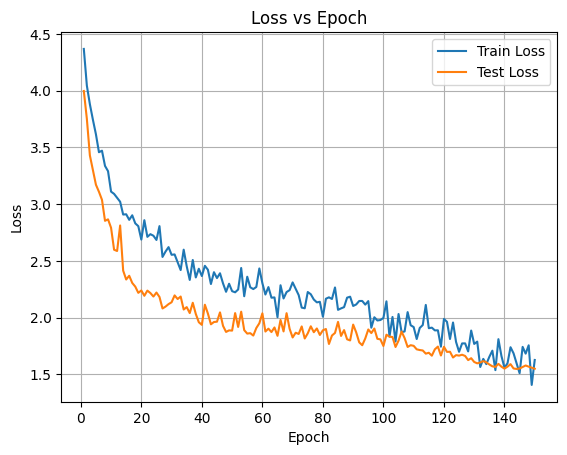

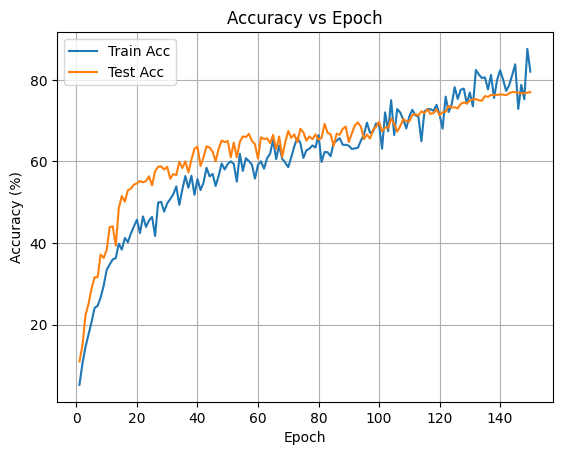

In [6]:
# Cell 6: Run training and plot curves

EPOCHS = 150
MAX_LR = 0.1

trained_model, history = train_resnet_cifar100(
    device=device,
    use_data_parallel=USE_DATA_PARALLEL,
    use_amp=USE_AMP,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    max_lr=MAX_LR,
    data_dir="./data",
    log_markdown_path="./training_logs_v2.md",
    model_ckpt_path="./best_resnet_cifar100_v2.pth",
)

plot_training_curves(history)


## Grad CAM

In [4]:
# Cell 1: Grad-CAM setup + load trained model weights

import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

# If not already defined, re-define CIFAR stats (harmless if duplicated)
CIFAR100_MEAN = (0.5071, 0.4867, 0.4408)
CIFAR100_STD  = (0.2675, 0.2565, 0.2761)

# ---- Denormalization for visualization ----
def denormalize_cifar100(img_tensor: torch.Tensor):
    """
    img_tensor: (3, H, W), normalized with CIFAR100_MEAN/STD
    returns: (3, H, W) in [0, 1]
    """
    device = img_tensor.device
    mean = torch.tensor(CIFAR100_MEAN, device=device).view(3, 1, 1)
    std = torch.tensor(CIFAR100_STD, device=device).view(3, 1, 1)
    img = img_tensor * std + mean
    img = img.clamp(0, 1)
    return img

# ---- Target layer helper for ResNet-18 (CIFAR) ----
def get_resnet_target_layer(model: torch.nn.Module):
    """
    For your ResNet-18 on CIFAR, use the last conv layer in layer4.
    Handles DataParallel transparently.
    """
    if isinstance(model, torch.nn.DataParallel):
        model = model.module
    return model.layer4[-1].conv2

# ---- Grad-CAM core class ----
class GradCAM:
    def __init__(self, model: torch.nn.Module, target_layer: torch.nn.Module, device: torch.device):
        self.model = model
        self.target_layer = target_layer
        self.device = device

        self.activations = None
        self.gradients = None

        # Register hooks
        self.fwd_hook = self.target_layer.register_forward_hook(self._forward_hook)
        self.bwd_hook = self.target_layer.register_backward_hook(self._backward_hook)

    def _forward_hook(self, module, inp, out):
        # Save feature maps (B, C, H, W)
        self.activations = out

    def _backward_hook(self, module, grad_in, grad_out):
        # grad_out[0] is gradient wrt activations (B, C, H, W)
        self.gradients = grad_out[0]

    def remove_hooks(self):
        self.fwd_hook.remove()
        self.bwd_hook.remove()

    def generate(self, input_tensor: torch.Tensor, target_class: int = None):
        """
        input_tensor: (1, 3, H, W), normalized, on self.device
        target_class: class index; if None, uses predicted class.
        returns: heatmap (H, W) np.ndarray in [0, 1]
        """
        self.model.eval()
        self.model.zero_grad()

        x = input_tensor.to(self.device)

        # Ensure gradients are tracked
        with torch.enable_grad():
            outputs = self.model(x)  # (1, num_classes)
            if target_class is None:
                target_class = outputs.argmax(dim=1).item()

            score = outputs[0, target_class]
            score.backward(retain_graph=True)

        # activations, gradients: (B, C, H, W)
        activations = self.activations
        gradients = self.gradients

        # Global average pool gradients over spatial dims: (B, C, 1, 1)
        weights = gradients.mean(dim=(2, 3), keepdim=True)

        # Weighted sum of activations → CAM
        cam = (weights * activations).sum(dim=1, keepdim=True)  # (B,1,H,W)
        cam = F.relu(cam)

        # Normalize and upsample to input size
        cam = cam[0]  # (1, H, W)
        cam = cam - cam.min()
        if cam.max() > 0:
            cam = cam / cam.max()

        _, _, H_in, W_in = x.shape
        cam_upsampled = F.interpolate(
            cam.unsqueeze(0), size=(H_in, W_in),
            mode="bilinear", align_corners=False
        )[0, 0]  # (H_in, W_in)

        return cam_upsampled.detach().cpu().numpy()

# ---- Visualization helper ----
def show_gradcam(img_tensor: torch.Tensor, heatmap: np.ndarray, title: str = "", alpha: float = 0.4):
    """
    img_tensor: (3, H, W), normalized
    heatmap: (H, W) np.ndarray in [0, 1]
    """
    img_denorm = denormalize_cifar100(img_tensor.cpu())
    img_np = img_denorm.permute(1, 2, 0).numpy()  # HWC

    plt.figure(figsize=(3, 3))
    plt.imshow(img_np)
    plt.imshow(heatmap, cmap="jet", alpha=alpha)
    plt.axis("off")
    if title:
        plt.title(title)
    plt.show()

# ---- Load trained model weights ----
# Assumes: resnet18_cifar(num_classes=100) and 'device' already defined.
ckpt_path = "./best_resnet_cifar100.pth"  # change if your file is elsewhere

base_model = resnet18_cifar(num_classes=100)  # your existing architecture
base_model.to(device)

# Load state dict (handle both plain and "model_state_dict")
checkpoint = torch.load(ckpt_path, map_location=device)
state_dict = checkpoint.get("model_state_dict", checkpoint)

# If trained with DataParallel, keys may be prefixed with "module."
if any(k.startswith("module.") for k in state_dict.keys()):
    from collections import OrderedDict
    new_state_dict = OrderedDict()
    for k, v in state_dict.items():
        new_state_dict[k.replace("module.", "", 1)] = v
    state_dict = new_state_dict

base_model.load_state_dict(state_dict)
base_model.eval()

model_for_cam = base_model  # keep a dedicated reference for Grad-CAM

print("Loaded model from:", ckpt_path)

Loaded model from: ./best_resnet_cifar100.pth


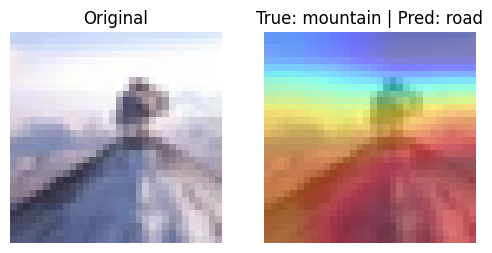

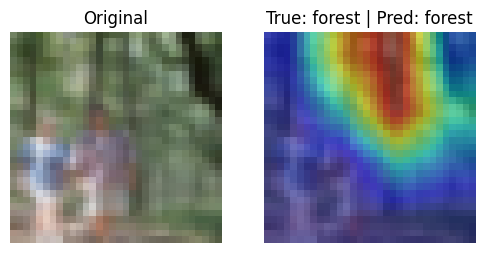

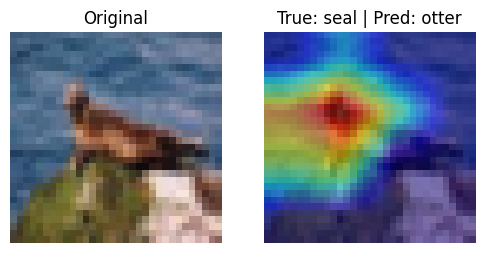

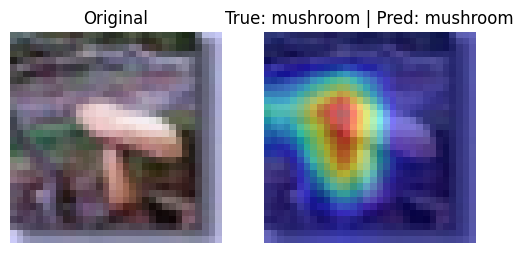

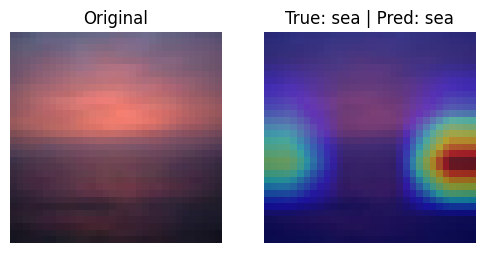

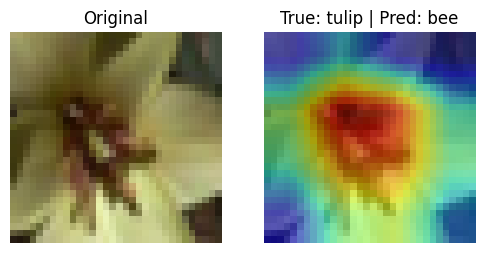

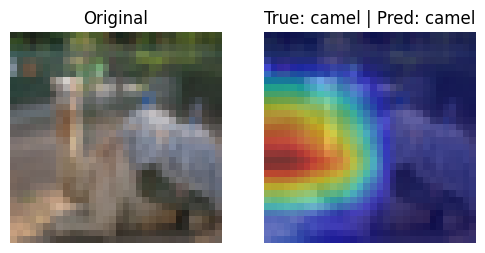

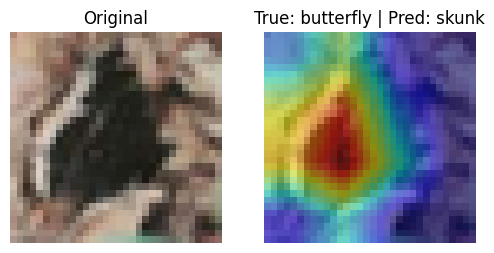

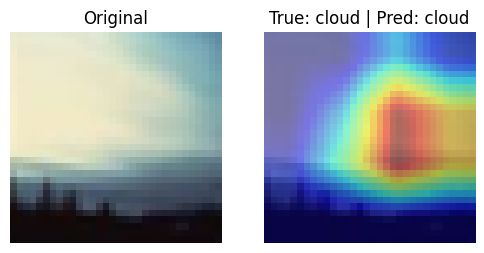

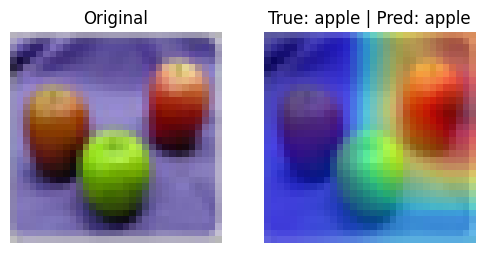

In [6]:
# Cell 2: Run Grad-CAM on 10 images, showing ORIGINAL + GRAD-CAM overlay

# Assumes: model_for_cam, device, GradCAM, get_resnet_target_layer,
#          denormalize_cifar100, testloader already defined.

# Try to get CIFAR-100 class names
class_names = getattr(testloader.dataset, "classes", None)

# Initialize Grad-CAM on last conv layer
target_layer = get_resnet_target_layer(model_for_cam)
gradcam = GradCAM(model_for_cam, target_layer, device=device)

# Fetch one batch
images, labels = next(iter(testloader))
B = images.size(0)
num_to_show = min(10, B)

for i in range(num_to_show):
    img = images[i:i+1].to(device)   # (1, 3, 32, 32)
    label = labels[i].item()

    # ---- Generate Grad-CAM heatmap ----
    heatmap = gradcam.generate(img, target_class=None)

    # ---- Get predictions ----
    with torch.no_grad():
        logits = model_for_cam(img)
        pred = logits.argmax(dim=1).item()

    true_name = class_names[label] if class_names is not None else str(label)
    pred_name = class_names[pred] if class_names is not None else str(pred)
    title = f"True: {true_name} | Pred: {pred_name}"

    # ---- Prepare images ----
    # Original image (denormalized)
    img_denorm = denormalize_cifar100(images[i]).permute(1, 2, 0).cpu().numpy()

    # Grad-CAM overlay map
    cam = heatmap  # (H, W)
    
    # ---- Plot side-by-side ----
    plt.figure(figsize=(6, 3))

    # Original
    plt.subplot(1, 2, 1)
    plt.imshow(img_denorm)
    plt.title("Original")
    plt.axis("off")

    # Grad-CAM overlay
    plt.subplot(1, 2, 2)
    plt.imshow(img_denorm)
    plt.imshow(cam, cmap="jet", alpha=0.5)
    plt.title(title)
    plt.axis("off")

    plt.show()

# Cleanup hooks if no longer needed
# gradcam.remove_hooks()